In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from tensorflow import keras
from sklearn.metrics import matthews_corrcoef, accuracy_score, root_mean_squared_error, mean_squared_error, mean_absolute_error, precision_score, confusion_matrix, multilabel_confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm
import time
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import gc
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import pickle

2025-04-19 22:33:07.075042: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745091187.103489  226112 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745091187.111956  226112 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745091187.133414  226112 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745091187.133440  226112 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745091187.133442  226112 computation_placer.cc:177] computation placer alr

# Functions

In [2]:
data_10000 = {}

In [3]:
def visualize_CM(matrix):
    """
    Visualize Correlation Matrix
    """
    sns.heatmap(matrix,annot=True)

def result_plot(_dict, name, folder, model_name):
    """
    Plot results for multiclass classification
    """
    with open('results_10000_mc.txt', 'a') as file:
        file.write(f"{name}: {_dict}")
    attacks = {}
    higher = ["F1", "Accuracy", "Precision", "Recall", "MCC", "precision", "recall", "f1-score", "support", 'Benign', 'Bruteforce', 'DDoS', 'DoS', 'Mirai', 'Recon', 'Spoofing',
       'Web']
    fig, ax = plt.subplots(figsize=(10,10))
    if name in higher:
        tmp = sorted(_dict.items(), key = lambda x:x[1])
    else:
        tmp = sorted(_dict.items(), key = lambda x:x[1], reverse=True)
    for x in tmp:
        attacks[x[0]] = x[1]
    ax.bar(attacks.keys(), attacks.values())
    rects = ax.patches
    results = [i for i in attacks.values()]
    labels = [f"{results[i]:.6f}" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom"
        )
    if name in higher:
        name = name.capitalize()
        ax.set_title(f'{name} (higher is better)', fontsize=16, fontweight="bold")
    else:
        ax.set_title(f'{name} (lower is better)', fontsize=16, fontweight="bold")
    ax.set_xlabel(f'{name}')
    ax.set_ylabel('Score')
    ax.grid(which='Major', axis='both')
    ax.set_axisbelow(True)
    if (model_name == ""):
        plt.savefig(f"images/results/{folder}/10000/{name}.png")
    else:
        plt.savefig(f"images/results/{folder}/10000/{name}_{model_name}.png")

def plot_mc(y_pred, y_test, model_name, mc_results = {}):
    """
    Plots Precision, Recall and F1 scores for each class in multiclass classification
    """
    cr = classification_report(y_pred, y_test, output_dict=True)
    for key, name in cr.items():
        if key not in ['accuracy', 'macro avg', 'weighted avg'] and int(key) in attack_dict:
            mc_results[attack_dict[int(key)]] = cr[key]
    mc_results = pd.DataFrame(mc_results).drop(['support'], axis = 0)
    for key in mc_results.keys():
        data_10000[key] = mc_results[key].to_dict()
    x = pd.DataFrame(data_10000).transpose().to_dict()
    with open('results_10000_precision.txt', 'a') as f:
        f.write(f"{model_name}: {x['precision']}")
    with open('results_10000_recall.txt', 'a') as f:
        f.write(f"{model_name}: {x['recall']}")
    with open('results_10000_f1.txt', 'a') as f:
        f.write(f"{model_name}: {x['f1-score']}")
    for key in mc_results.keys():
        result_plot(mc_results[key], key, "multiclass_by_class", model_name)

# Load data

In [4]:
data = pd.read_csv('data/CIC_IoT2023/custom/multiclass_classification_data_10000.csv')

In [5]:
data = data.drop(['Unnamed: 0', 'label', 'Class'], axis=1)

In [6]:
data.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Attack Type
0,0.0,0.0,0.99,65.27,1.232415,1.232415,0.0,0.0,0.0,0.0,...,0.617394,42.18,8.312856e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55,DDoS
1,0.0,54.0,6.00,64.00,31.840037,31.840037,0.0,0.0,1.0,0.0,...,0.000000,54.00,8.309343e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS
2,0.0,0.0,0.99,63.36,2.481472,2.481472,0.0,0.0,0.0,0.0,...,0.617394,42.18,8.314964e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55,DDoS
3,0.0,54.0,6.00,64.00,4.499163,4.499163,0.0,0.0,0.0,0.0,...,0.000000,54.00,8.333215e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS
4,0.0,54.0,6.00,64.00,15.849033,15.849033,0.0,0.0,0.0,0.0,...,0.000000,54.00,8.307156e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS


In [7]:
data.tail()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Attack Type
79995,54.271849,45513.8,7.1,71.2,54.273523,54.273523,0.0,0.0,0.0,0.0,...,566.859782,236.2,1.666014e+08,13.5,28.282265,803.694633,323657.383319,1.0,244.6,Bruteforce
79996,38.187217,7522.1,7.1,80.9,1.922473,1.922473,0.0,0.0,0.0,0.0,...,50.982149,81.6,1.666014e+08,13.5,13.568187,72.255303,2613.451334,1.0,244.6,Bruteforce
79997,88.070245,10869.8,17.0,83.1,2.075852,2.075852,0.0,0.0,0.0,0.0,...,44.825245,108.4,1.266160e-02,5.5,12.600532,63.392470,3191.548259,0.9,38.5,Bruteforce
79998,24890.841171,5669.7,7.1,83.1,14.413761,14.413761,0.0,0.0,0.0,0.0,...,102.193985,110.2,1.666013e+08,13.5,15.791364,144.858449,10538.675975,1.0,244.6,Bruteforce
79999,33.218726,1877.5,6.5,66.1,33.508903,33.508903,0.0,0.0,0.0,0.0,...,438.300834,605.3,1.336191e-02,5.5,23.452670,619.850983,365070.018755,0.9,38.5,Bruteforce


In [8]:
X = data.drop(['Attack Type'], axis = 1)
y = data['Attack Type']

In [9]:
X.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,AVG,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight
0,0.0,0.0,0.99,65.27,1.232415,1.232415,0.0,0.0,0.0,0.0,...,42.180879,0.617394,42.18,8.312856e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55
1,0.0,54.0,6.00,64.00,31.840037,31.840037,0.0,0.0,1.0,0.0,...,54.000000,0.000000,54.00,8.309343e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55
2,0.0,0.0,0.99,63.36,2.481472,2.481472,0.0,0.0,0.0,0.0,...,42.180879,0.617394,42.18,8.314964e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55
3,0.0,54.0,6.00,64.00,4.499163,4.499163,0.0,0.0,0.0,0.0,...,54.000000,0.000000,54.00,8.333215e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55
4,0.0,54.0,6.00,64.00,15.849033,15.849033,0.0,0.0,0.0,0.0,...,54.000000,0.000000,54.00,8.307156e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55


In [10]:
y

0              DDoS
1              DDoS
2              DDoS
3              DDoS
4              DDoS
            ...    
79995    Bruteforce
79996    Bruteforce
79997    Bruteforce
79998    Bruteforce
79999    Bruteforce
Name: Attack Type, Length: 80000, dtype: object

In [11]:
le = LabelEncoder()

data['Attack Number'] = le.fit_transform(y)
y = data['Attack Number']

In [12]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [13]:
attack_dict = {}
encoded_values = data['Attack Number'].unique()
for val in sorted(encoded_values):
    attack_dict[val] = le.inverse_transform([val])[0]
    print(f"{val}: {le.inverse_transform([val])[0]}")

0: Benign
1: Bruteforce
2: DDoS
3: DoS
4: Mirai
5: Recon
6: Spoofing
7: Web


# Multiclass Classification

In [14]:
results_dict = {}

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((68000, 46), (68000,), (12000, 46), (12000,))

# K Nearest Neighbour

In [91]:
%%time

start = time.time()

knn_clf = KNeighborsClassifier(n_jobs=8)
knn_clf.fit(X_train, y_train)
y_pred = knn_clf.predict(X_test)

end = time.time()

KNN_time = end - start

CPU times: user 4.47 s, sys: 18.8 ms, total: 4.49 s
Wall time: 1.15 s


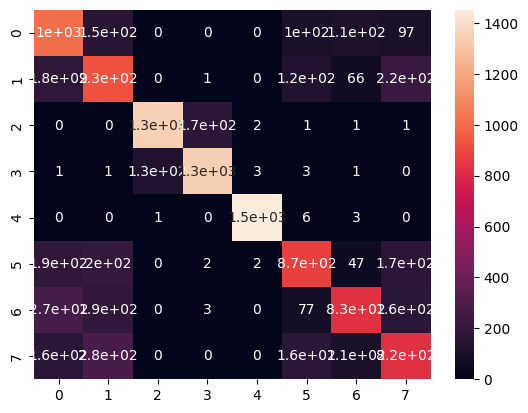

In [19]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [92]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [93]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, KNN_time]
results_dict["kNN"] = results

In [94]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [95]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.710167,0.717006,0.710863,0.710167,0.669535,1.092,5.5575,2.357435,1.153106


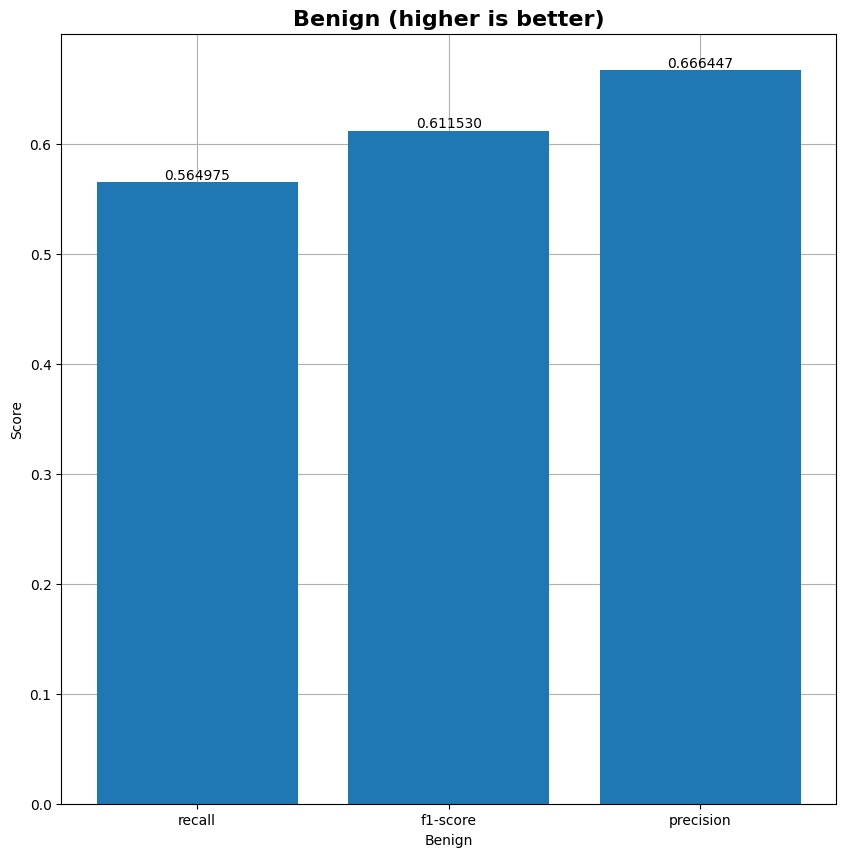

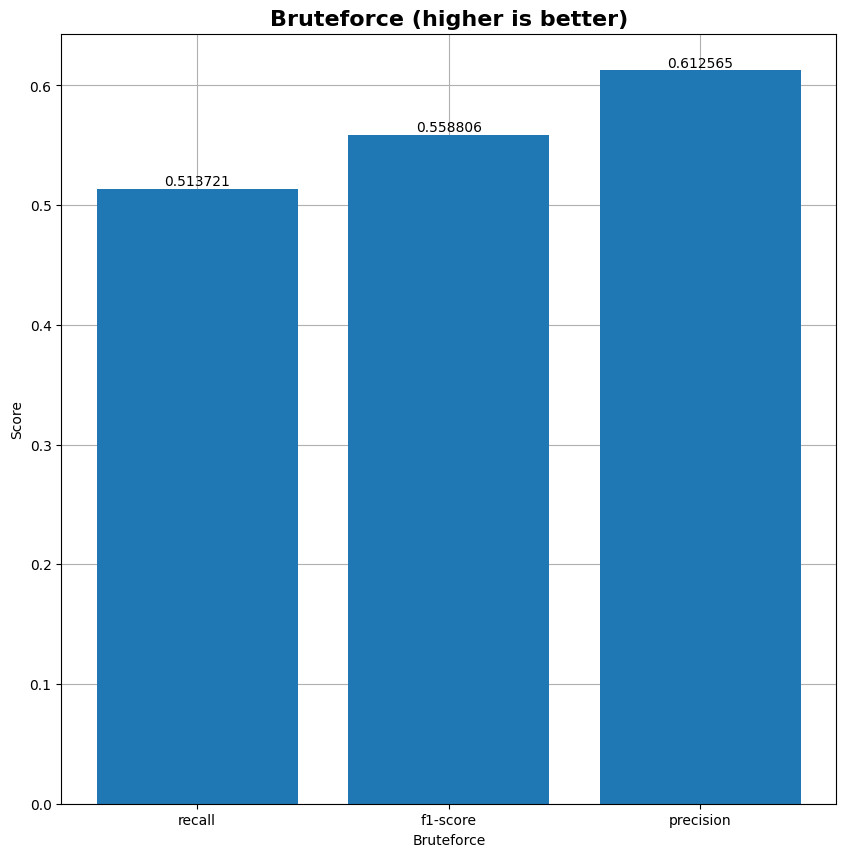

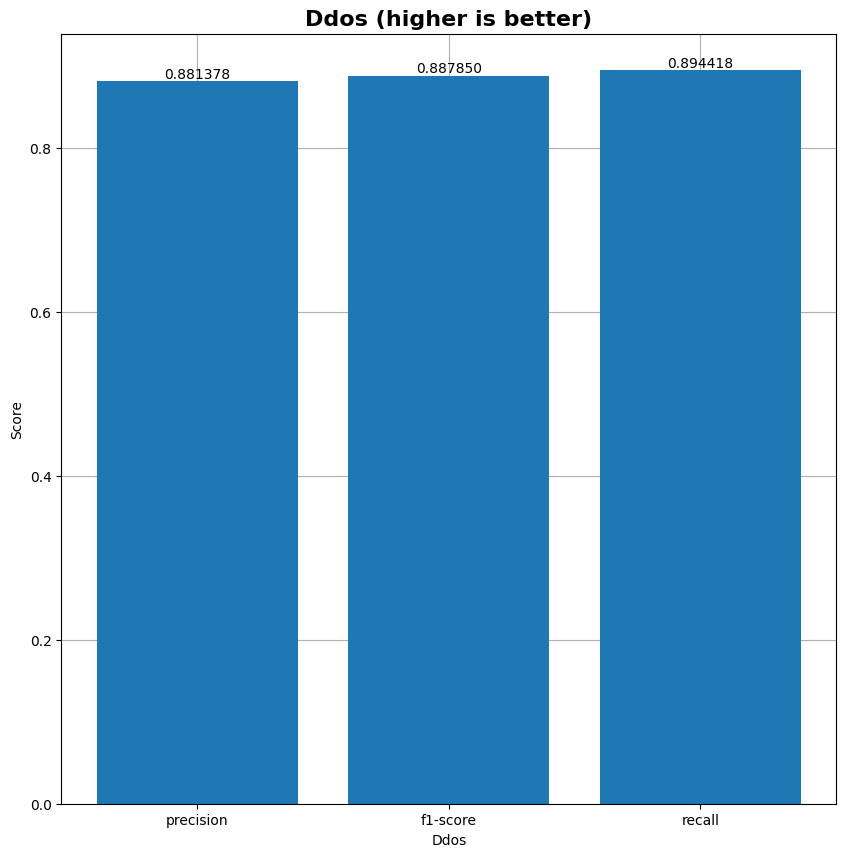

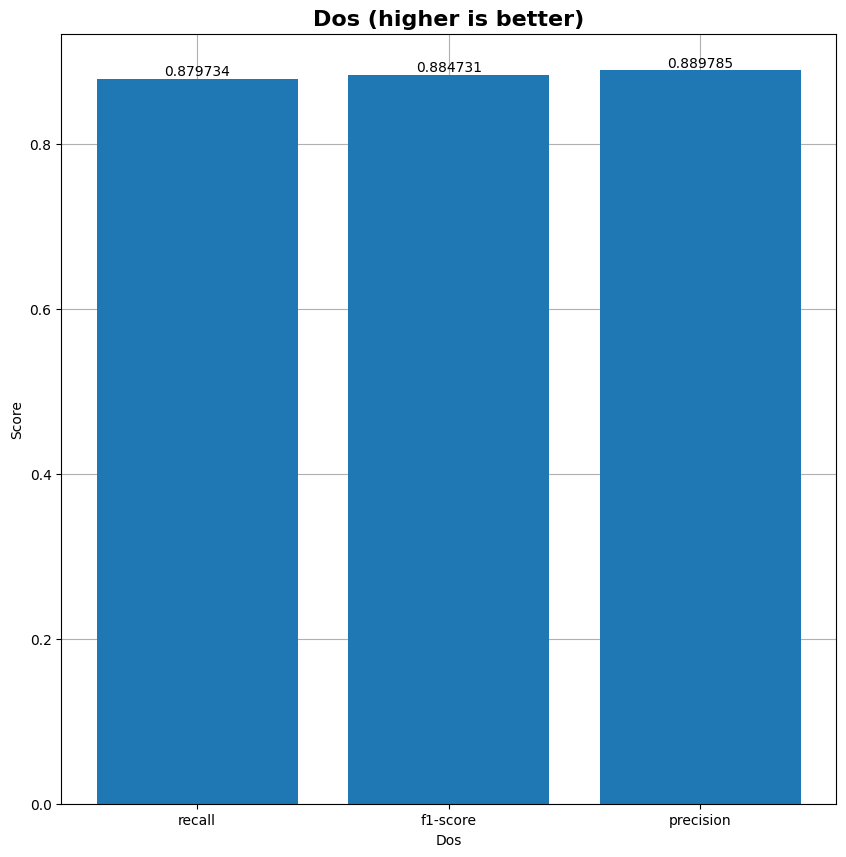

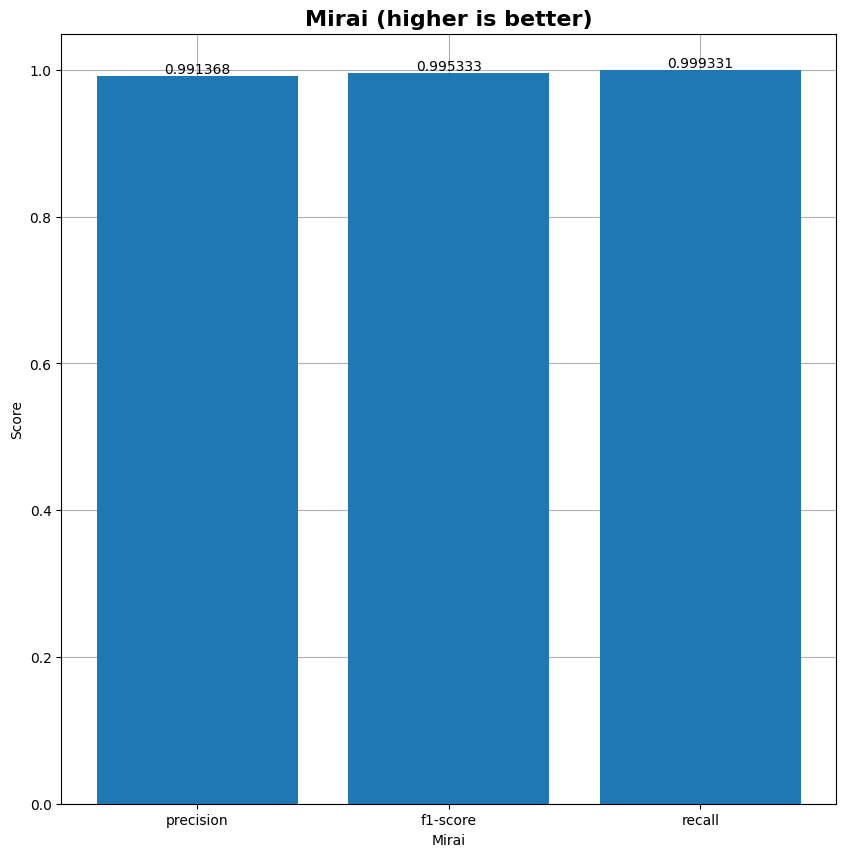

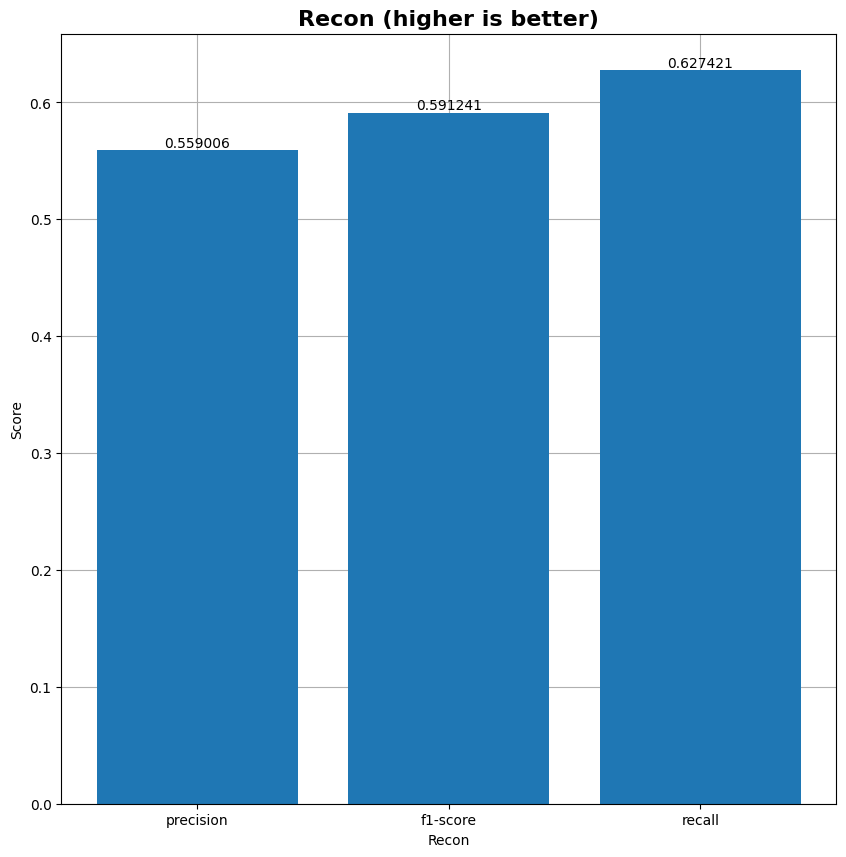

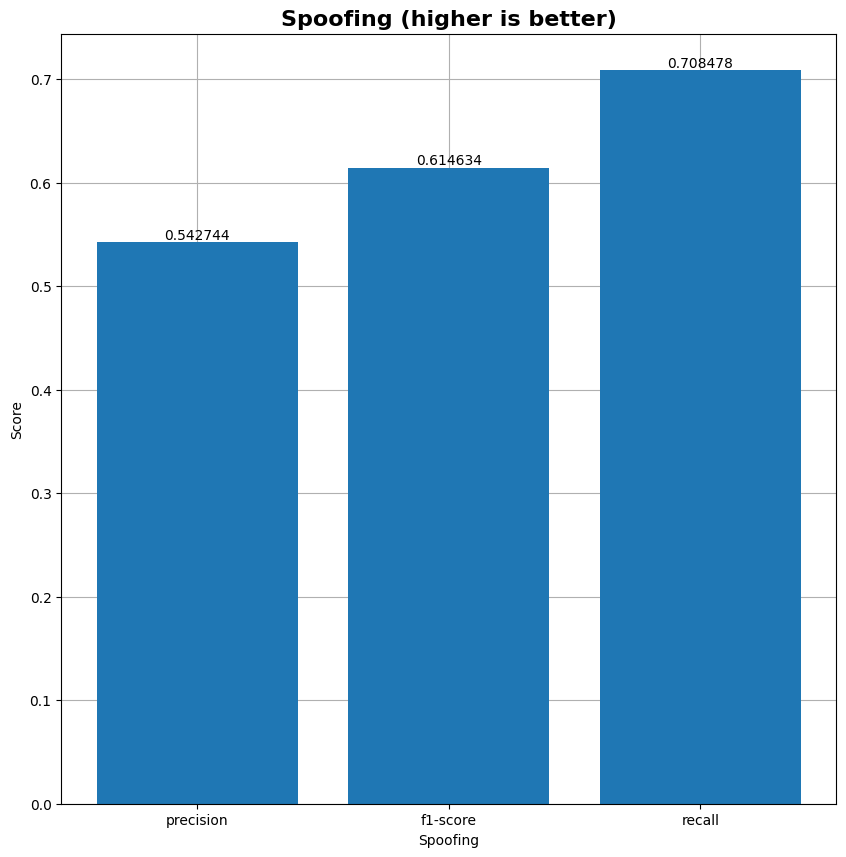

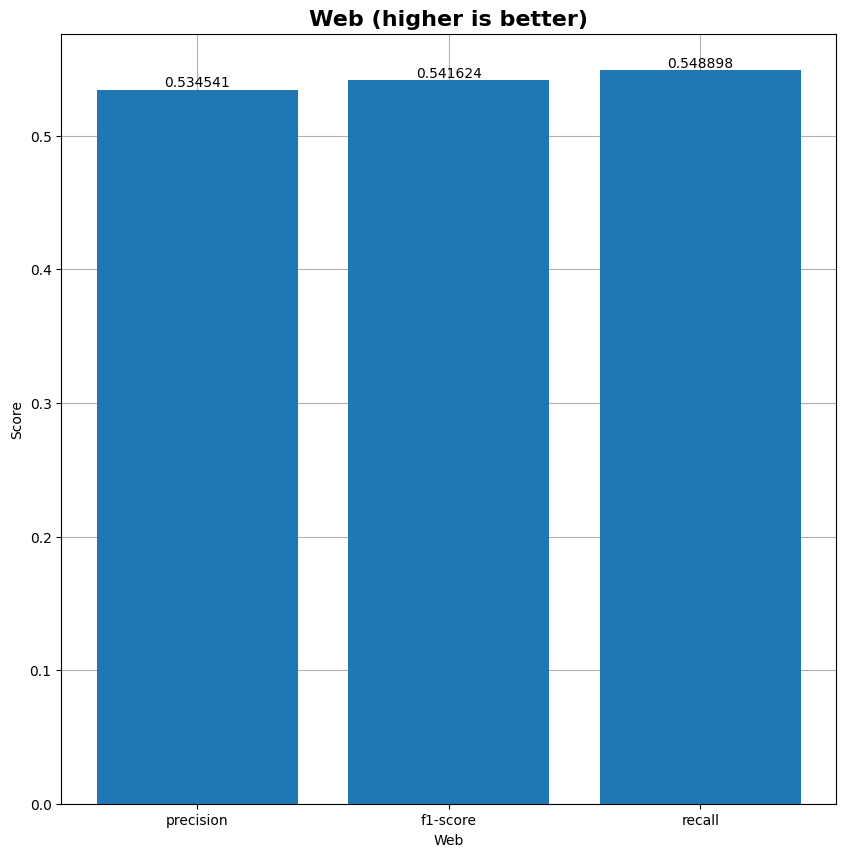

In [96]:
plot_mc(y_pred, y_test, "kNN")

In [ ]:
model_name = "kNN_10000.sav"
pickle.dump(knn_clf, open(model_name, 'wb'))

# Logistic Regression

In [ ]:
%%time

start = time.time()

lr_clf = LogisticRegression(max_iter = 10000, C = 0.1, random_state = 0, solver = 'saga', n_jobs=8)
lr_clf.fit(X_train, y_train)
y_pred = lr_clf.predict(X_test)

end = time.time()

LR_time = end - start

In [ ]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [ ]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [ ]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, LR_time]
results_dict["LR"] = results

In [ ]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [ ]:
results_df

In [ ]:
plot_mc(y_pred, y_test, "LR")

In [ ]:
model_name = "LR_10000.sav"
pickle.dump(lr_clf, open(model_name, 'wb'))

# Random Forest

In [16]:
%%time

start = time.time()

rf_clf = RandomForestClassifier(n_jobs=8)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

end = time.time()

RF_time = end - start

CPU times: user 27 s, sys: 185 ms, total: 27.1 s
Wall time: 4.23 s


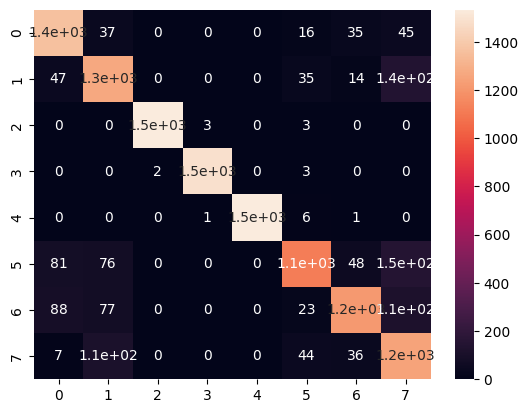

In [17]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [18]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [19]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, RF_time]
results_dict["RF"] = results

In [20]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [21]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
RF,0.896583,0.900818,0.896908,0.896583,0.882344,0.393167,1.973333,1.404754,4.234497


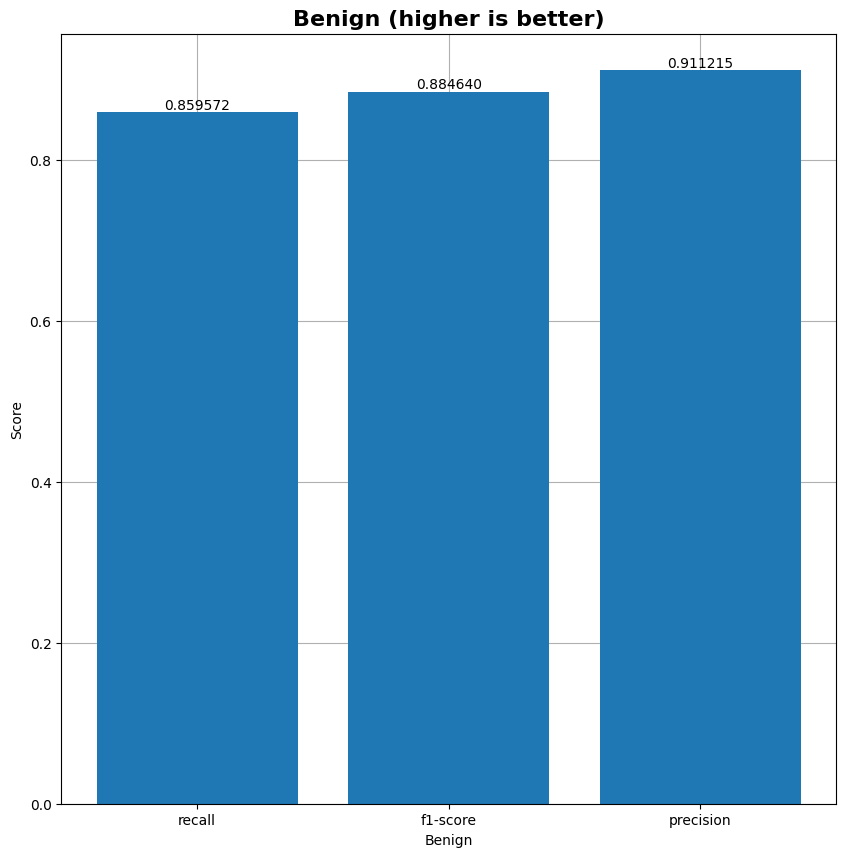

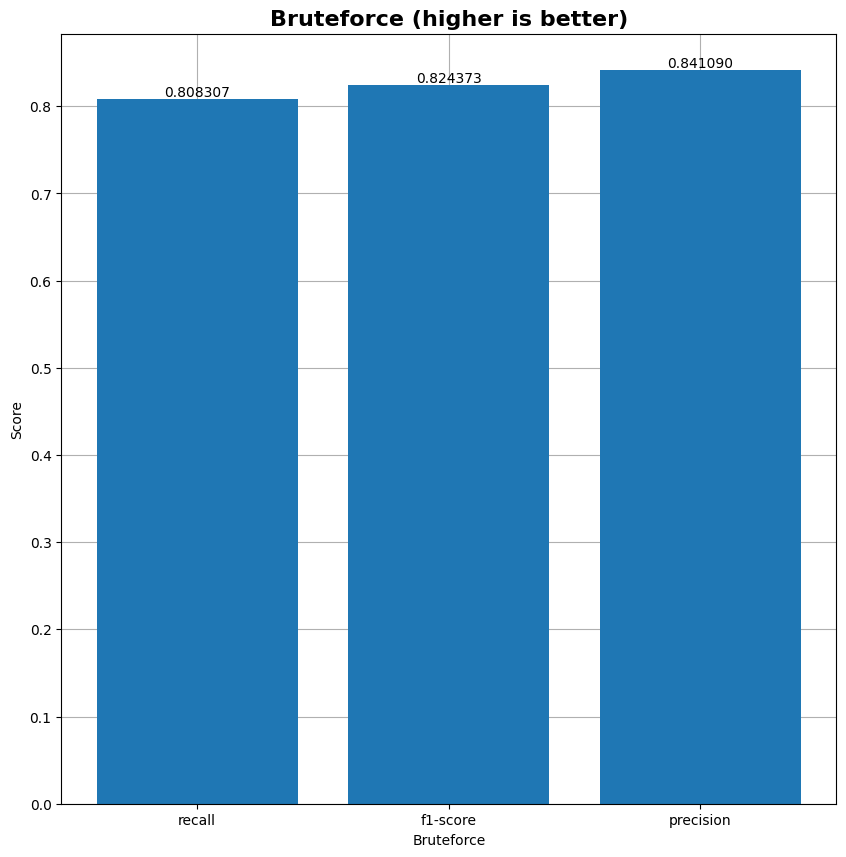

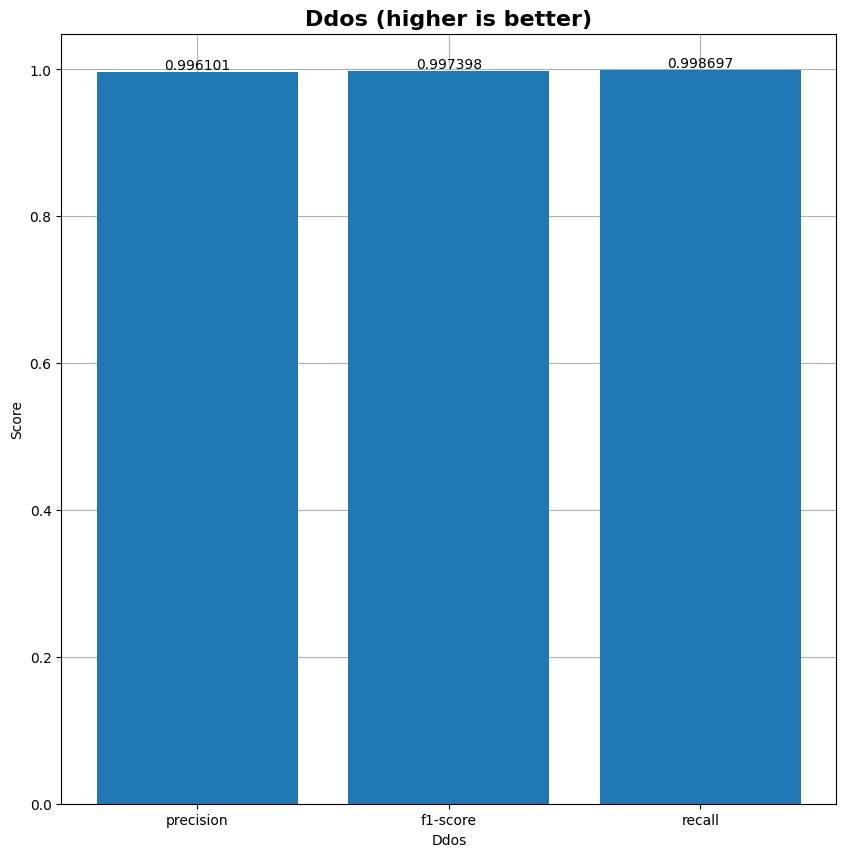

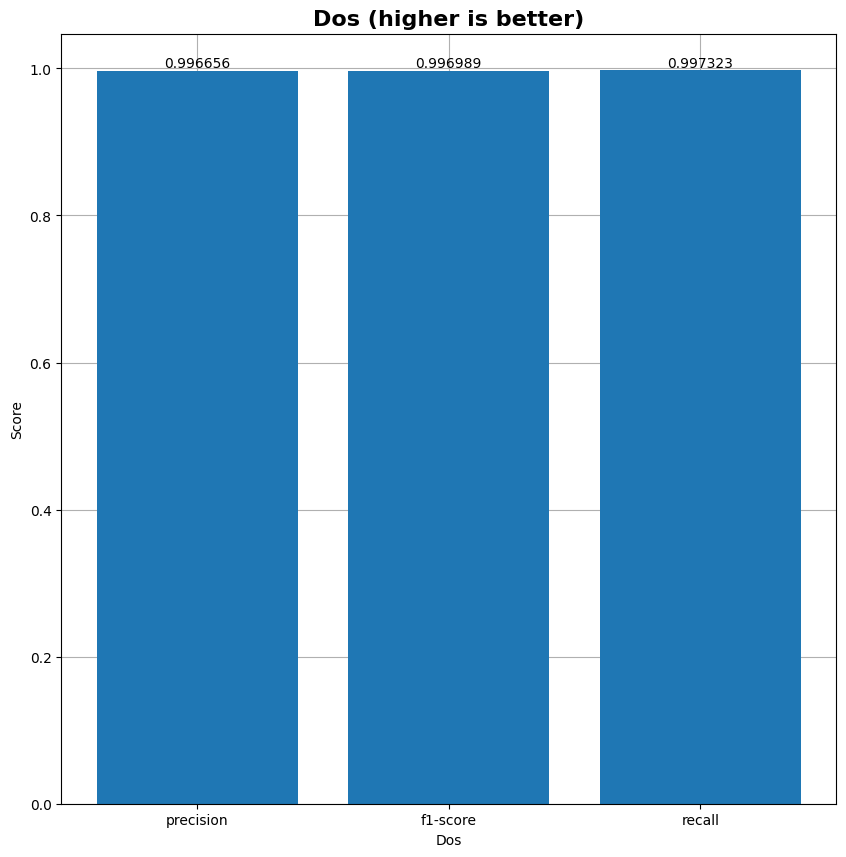

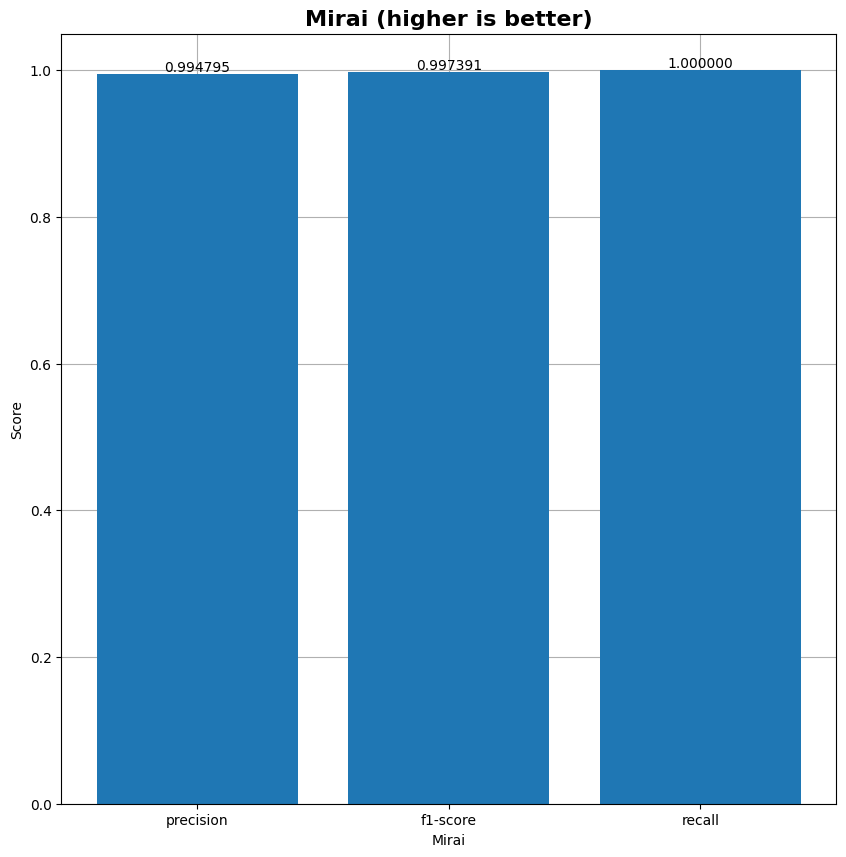

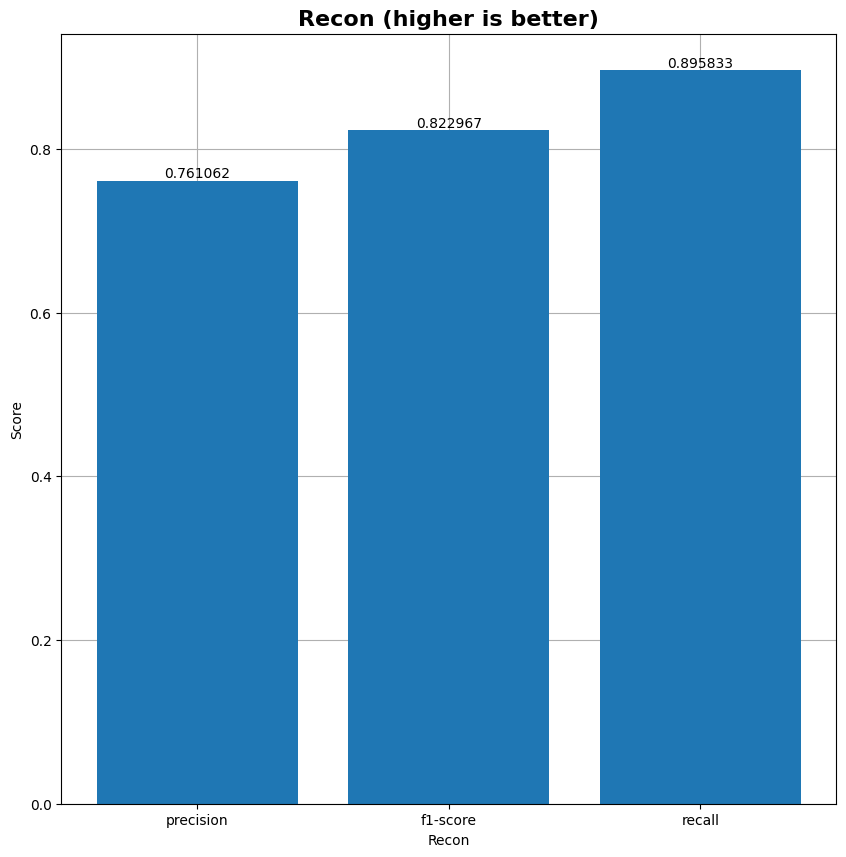

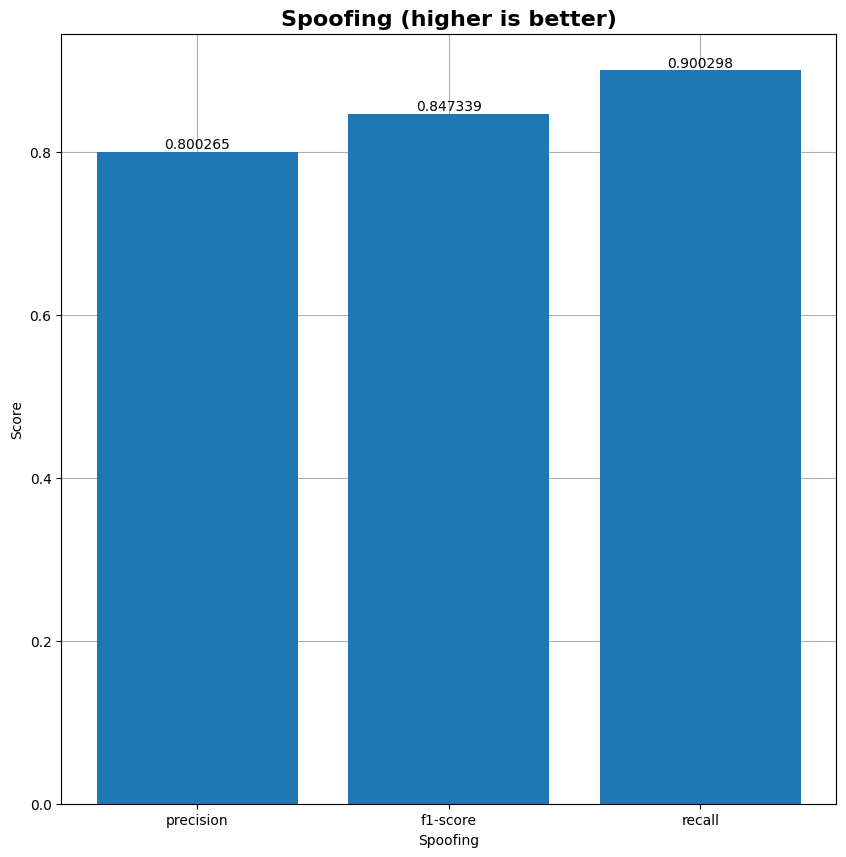

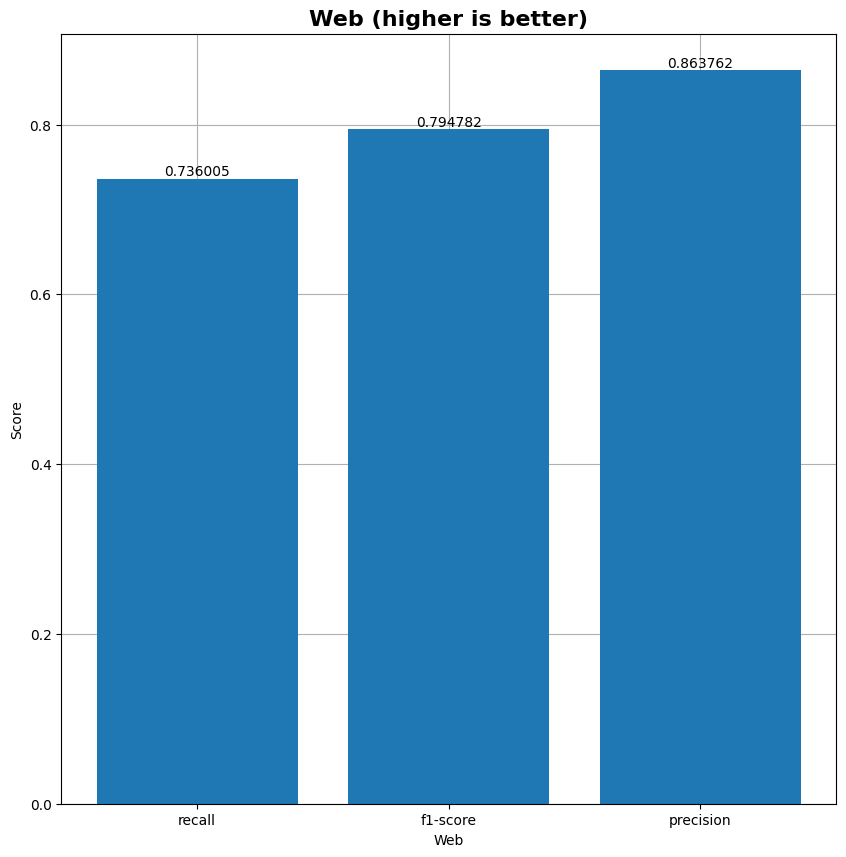

In [22]:
plot_mc(y_pred, y_test, "RF")

In [ ]:
model_name = "RF_10000.sav"
pickle.dump(rf_clf, open(model_name, 'wb'))

# XGBoost

In [102]:
%%time

start = time.time()

xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

end = time.time()

XGB_time = end - start

CPU times: user 38.4 s, sys: 285 ms, total: 38.7 s
Wall time: 5.46 s


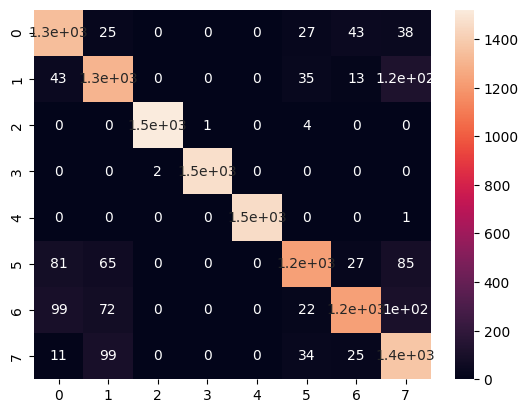

In [33]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [103]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [104]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, XGB_time]
results_dict["XGBoost"] = results

In [105]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [106]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.710167,0.717006,0.710863,0.710167,0.669535,1.092000,5.557500,2.357435,1.153106
RF,0.891667,0.895353,0.891747,0.891667,0.876699,0.404750,2.019083,1.420945,4.113602
XGBoost,0.908000,0.911600,0.908041,0.908000,0.895363,0.358583,1.804250,1.343224,5.455152


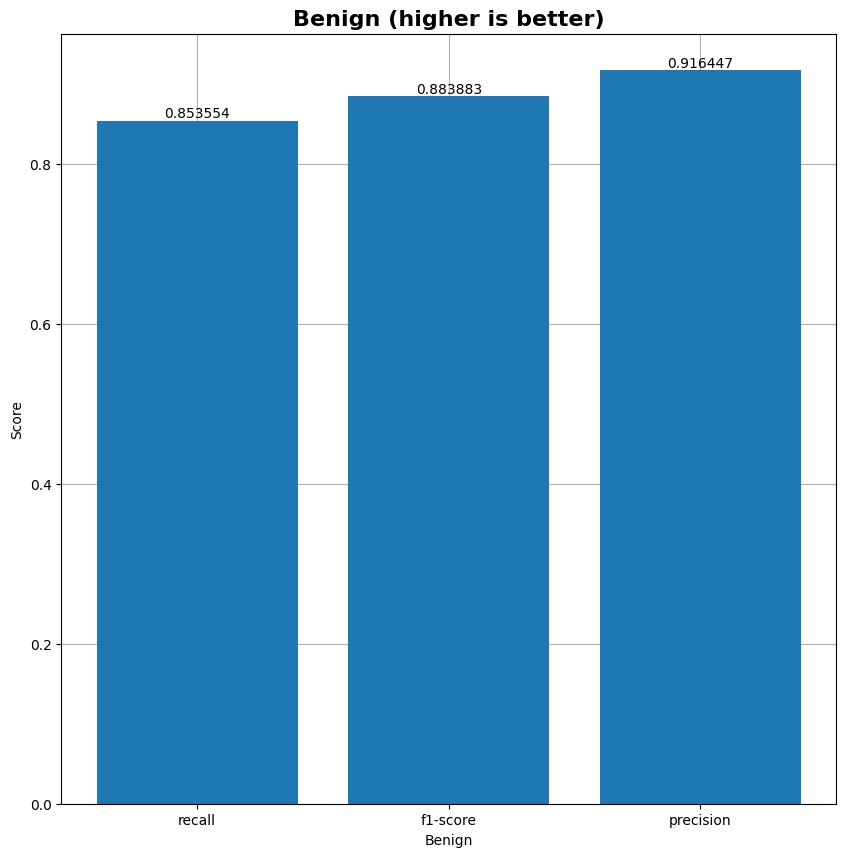

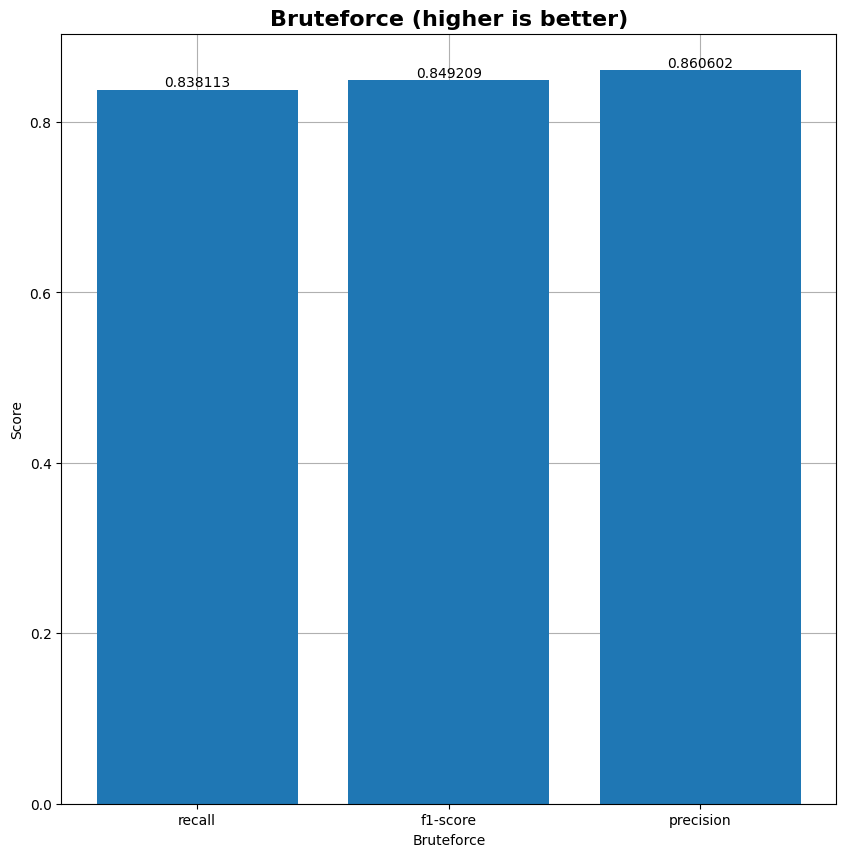

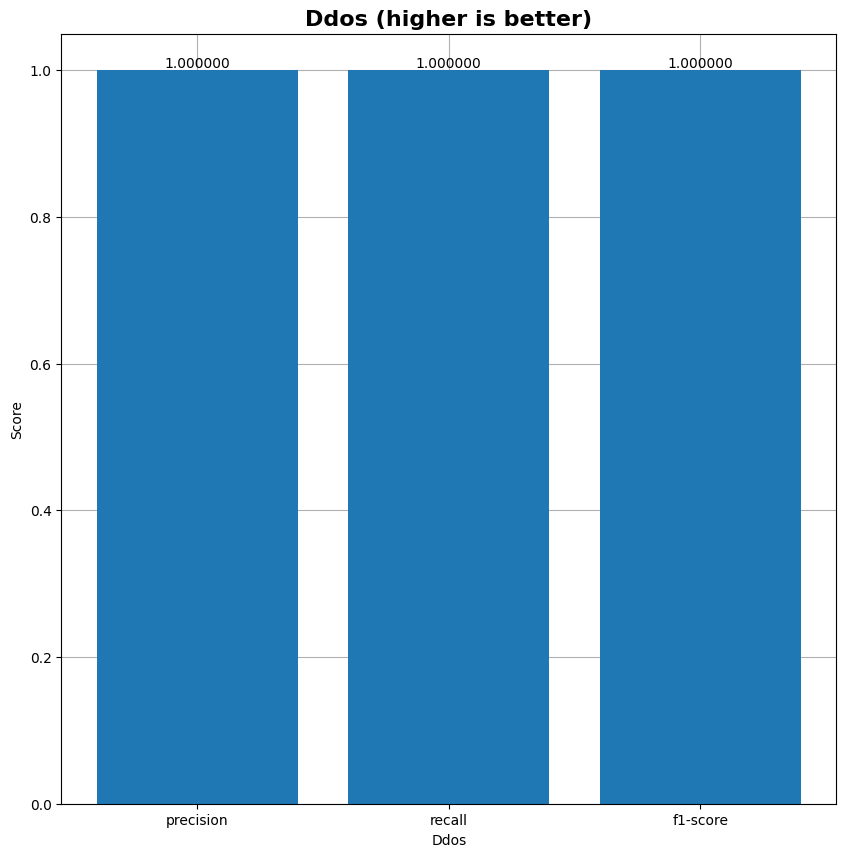

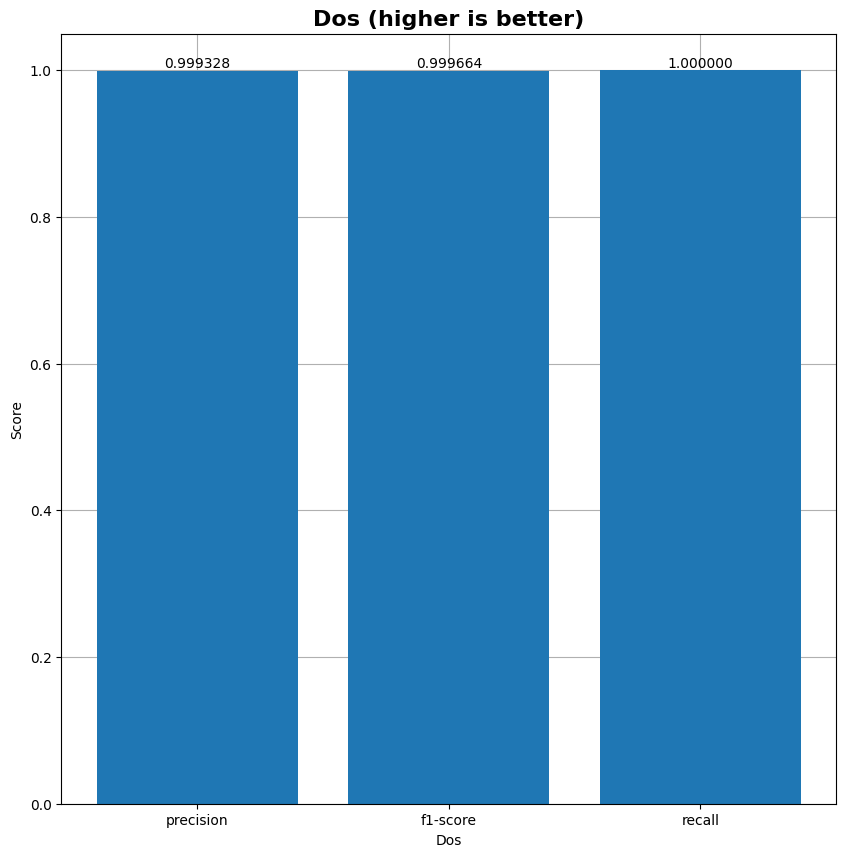

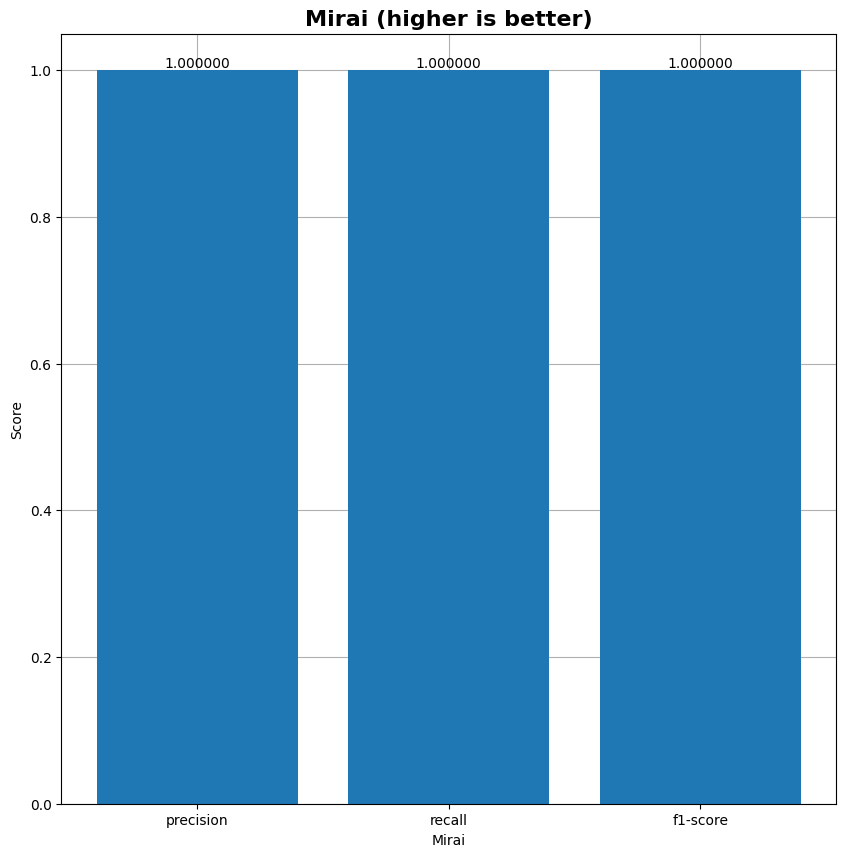

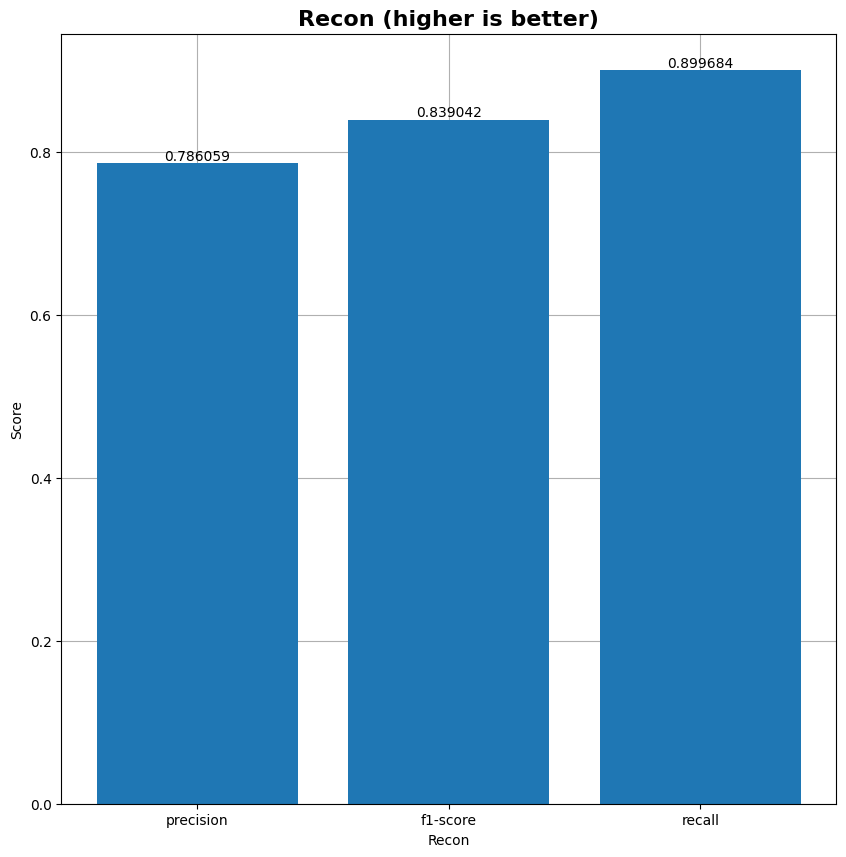

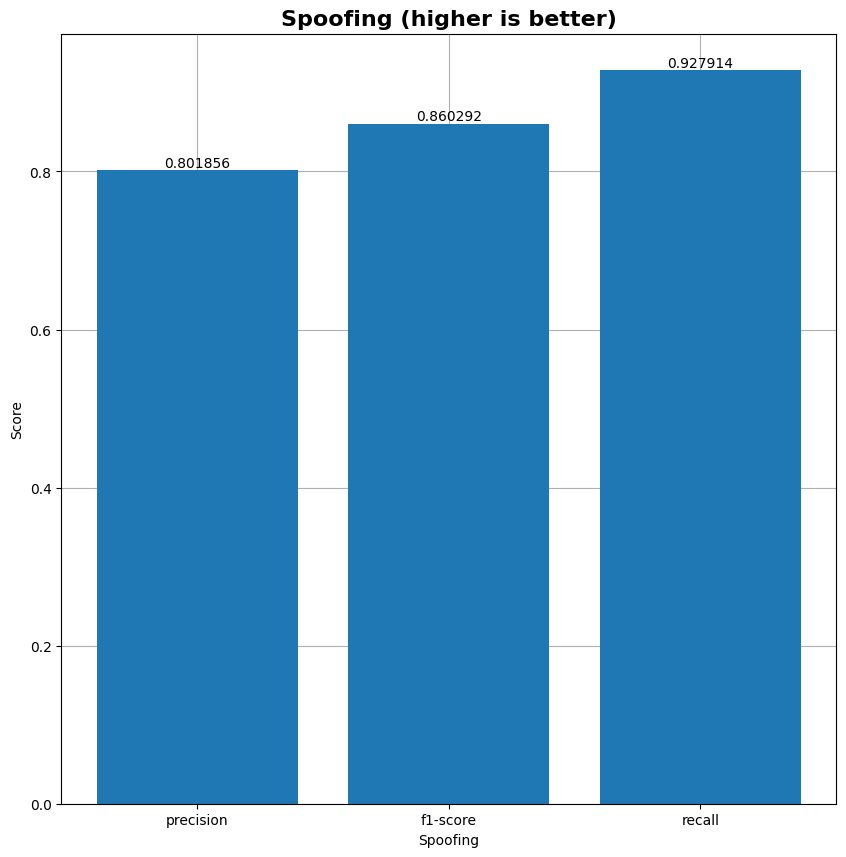

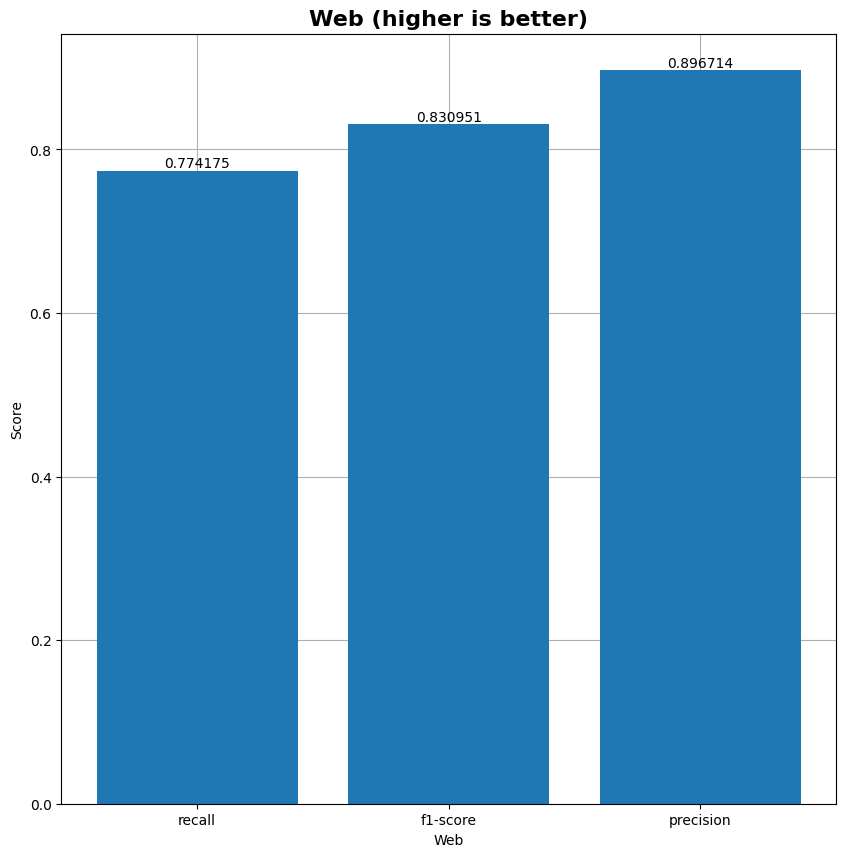

In [107]:
plot_mc(y_pred, y_test, "XGBoost")

In [ ]:
model_name = "XGB_10000.sav"
pickle.dump(xgb_clf, open(model_name, 'wb'))

# LightGBM

In [108]:
%%time

start = time.time()

lgbm_clf = lightgbm.LGBMClassifier()
lgbm_clf.fit(X_train, y_train)
y_pred = lgbm_clf.predict(X_test)

end = time.time()

LightGBM_Time = end - start

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5202
[LightGBM] [Info] Number of data points in the train set: 68000, number of used features: 39
[LightGBM] [Info] Start training from score -2.081797
[LightGBM] [Info] Start training from score -2.082741
[LightGBM] [Info] Start training from score -2.080501
[LightGBM] [Info] Start training from score -2.078031
[LightGBM] [Info] Start training from score -2.080148
[LightGBM] [Info] Start training from score -2.073459
[LightGBM] [Info] Start training from score -2.080501
[LightGBM] [Info] Start training from score -2.078383


/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


CPU times: user 14.1 s, sys: 133 ms, total: 14.3 s
Wall time: 3.65 s


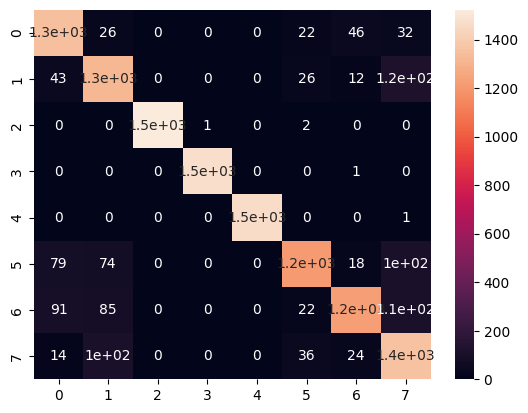

In [40]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [109]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [110]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, LightGBM_Time]
results_dict["LightGBM"] = results

In [111]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [112]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.710167,0.717006,0.710863,0.710167,0.669535,1.092000,5.557500,2.357435,1.153106
RF,0.891667,0.895353,0.891747,0.891667,0.876699,0.404750,2.019083,1.420945,4.113602
XGBoost,0.908000,0.911600,0.908041,0.908000,0.895363,0.358583,1.804250,1.343224,5.455152
LightGBM,0.905833,0.909963,0.905908,0.905833,0.892957,0.369417,1.876250,1.369763,3.653643


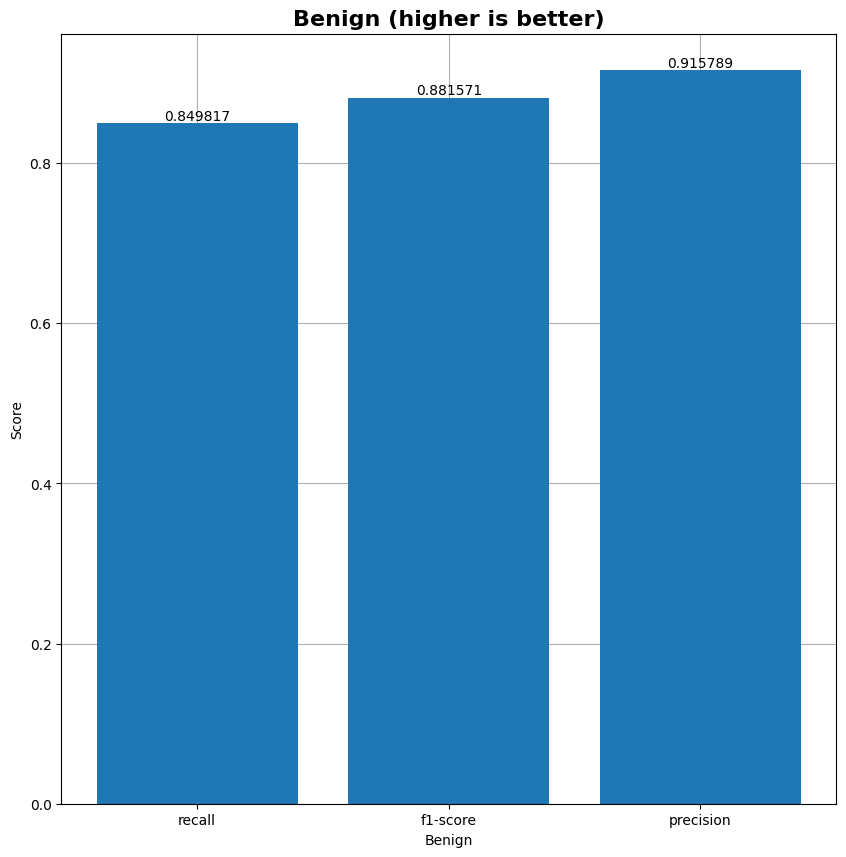

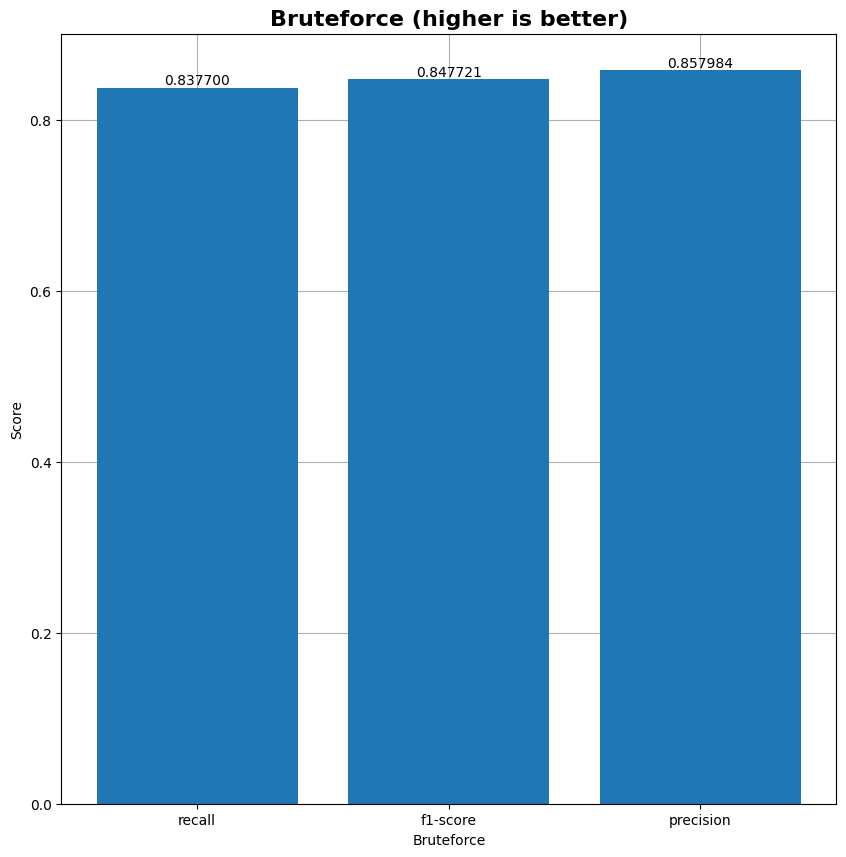

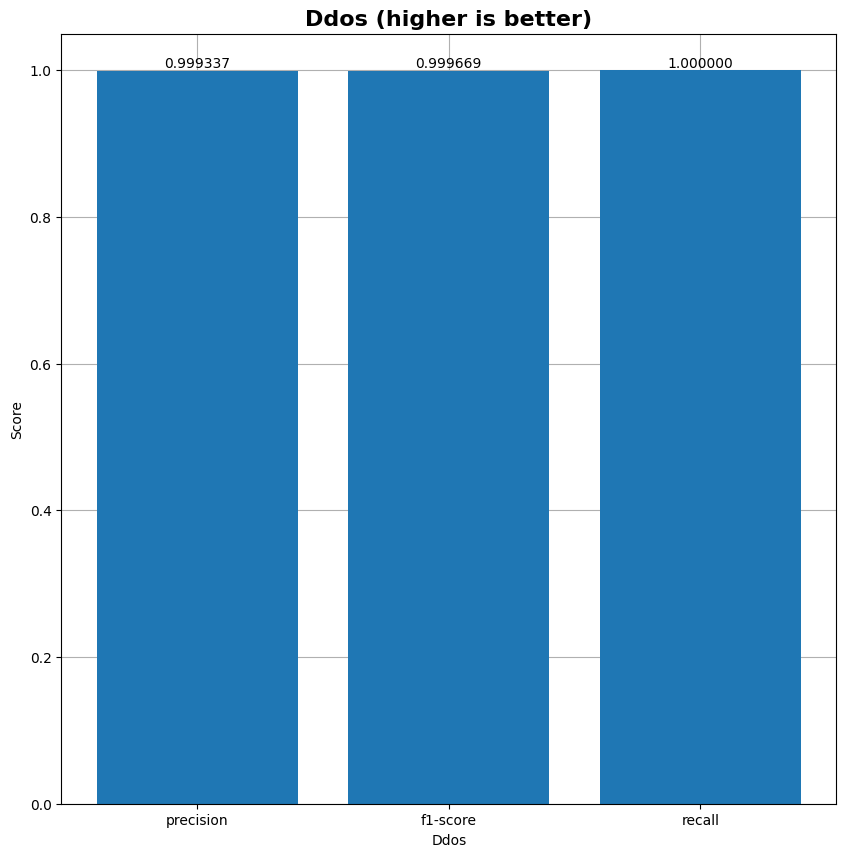

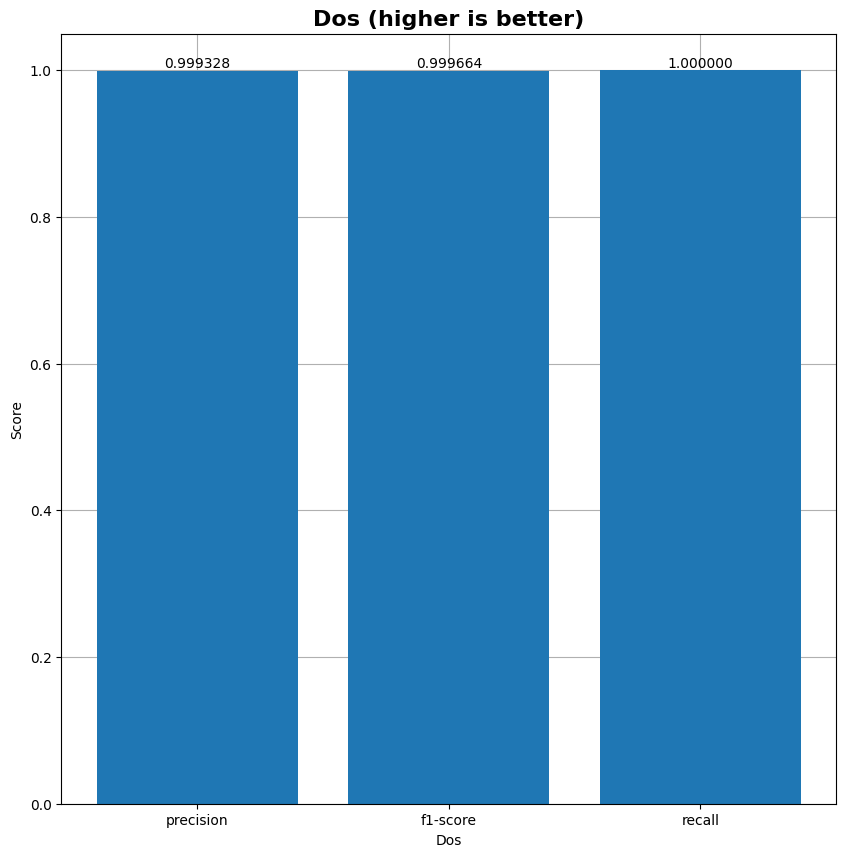

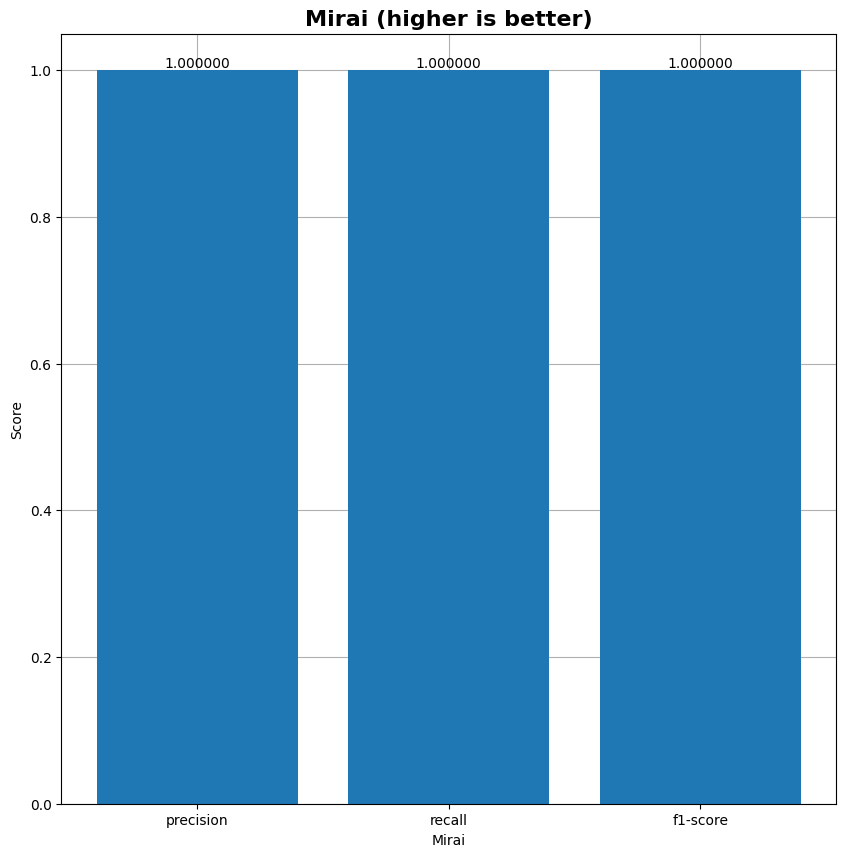

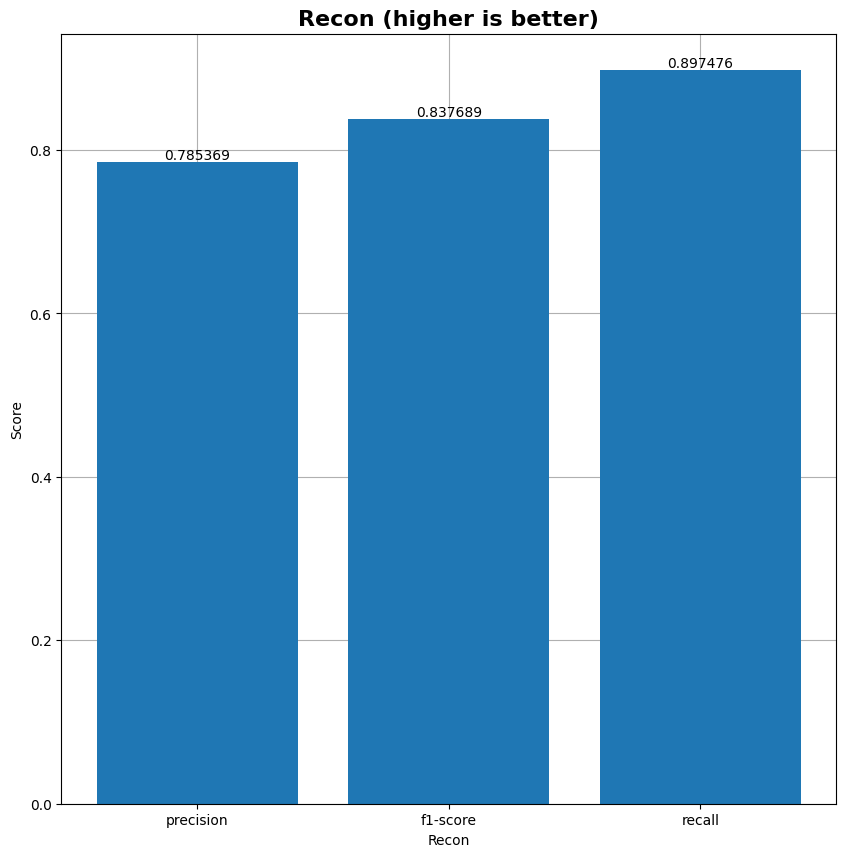

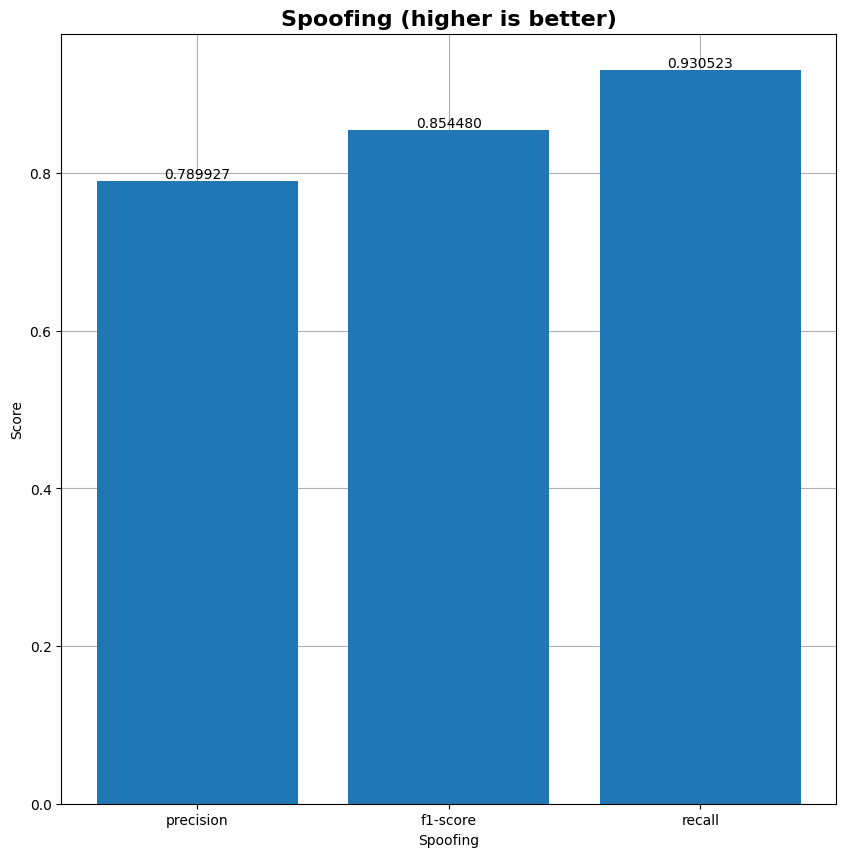

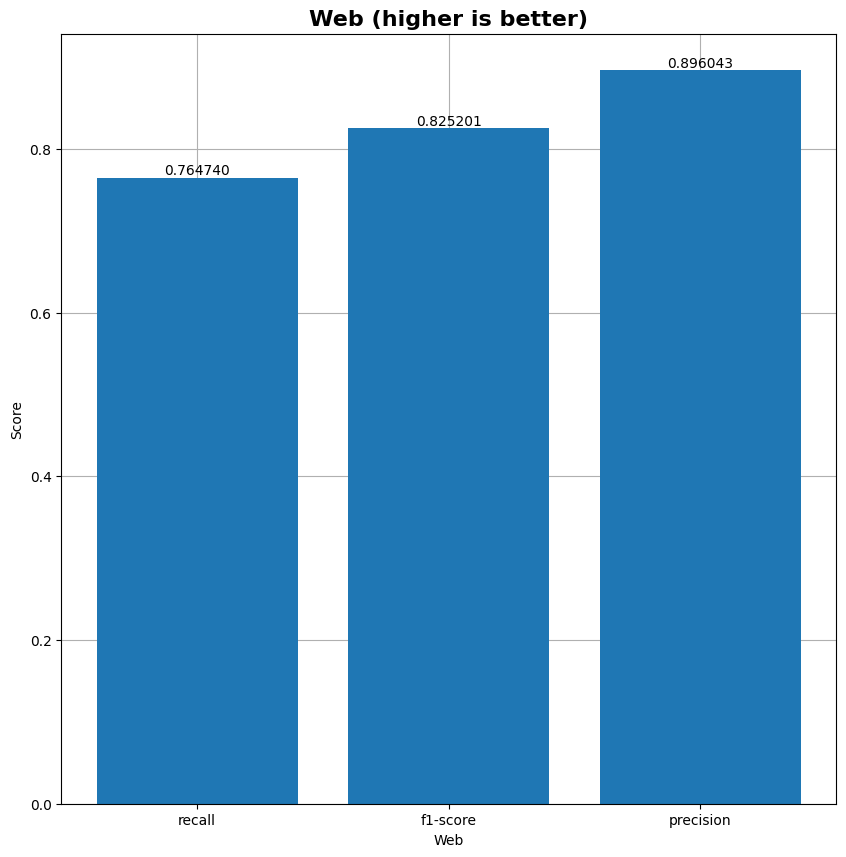

In [113]:
plot_mc(y_pred, y_test, "LightGBM")

In [ ]:
model_name = "LightGBM_10000.sav"
pickle.dump(lgbm_clf, open(model_name, 'wb'))

# Support Vector Machine

In [ ]:
%%time

start = time.time()

svm_clf = SVC(kernel = 'poly', C = 1, random_state = 0, probability = True)
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)

end = time.time()

SVM_Time = end - start

In [ ]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [ ]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [ ]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, SVM_Time]
results_dict["SVM"] = results

In [ ]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [ ]:
results_df

In [ ]:
plot_mc(y_pred, y_test, "SVM")

In [ ]:
model_name = "SVM_10000.sav"
pickle.dump(svm_clf, open(model_name, 'wb'))

# Feed Forward Neural Network

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((55760, 46), (55760,), (12240, 46), (12240,), (12000, 46), (12000,))

In [115]:
def create_model(X_train, y_train):
    model = keras.Sequential()
    model.add(keras.layers.Dense(X_train.shape[1], activation='relu', input_shape=(X_train.shape[1],)))
    model.add(keras.layers.Dense(1024, activation='relu'))
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dense(len(np.unique(y_train)), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
model = create_model(X_train, y_train)

/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [116]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 46)             │         2,162 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1024)           │        48,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 579,194 (2.21 MB)

 Trainable params: 579,194 (2.21 MB)

 Non-trainable params: 0 (0.00 B)

In [117]:
%%time

start = time.time()

model.fit(X_train, y_train,
          batch_size=16,
          epochs=20,
          validation_data=(X_val, y_val))
gc.collect();

y_pred = model.predict(X_test)

end = time.time()

FFNN_Time = end - start

Epoch 1/20
3485/3485 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.6255 - loss: 0.9063 - val_accuracy: 0.6915 - val_loss: 0.7581
Epoch 2/20
3485/3485 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.6967 - loss: 0.7251 - val_accuracy: 0.7043 - val_loss: 0.7144
Epoch 3/20
3485/3485 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7099 - loss: 0.6947 - val_accuracy: 0.7178 - val_loss: 0.6869
Epoch 4/20
3485/3485 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7226 - loss: 0.6737 - val_accuracy: 0.7203 - val_loss: 0.6766
Epoch 5/20
3485/3485 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7302 - loss: 0.6535 - val_accuracy: 0.7277 - val_loss: 0.6688
Epoch 6/20
3485/3485 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7382 - loss: 0.6336 - val_accuracy: 0.7346 - val_loss: 0.6564
Epoch 7/20
3485/3485 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7422 - loss: 0.6216 - val_accuracy: 0.7245 - val_loss: 0.6636
Epoch 8/20
3485/3485 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7414 - loss: 0.6218

In [118]:
y_pred = np.argmax(y_pred, axis=1)

In [119]:
_, accuracy = model.evaluate(X_test, y_test)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7387 - loss: 0.6651    


In [120]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, FFNN_Time]
results_dict["FF-NN"] = results

In [121]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [122]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.710167,0.717006,0.710863,0.710167,0.669535,1.092000,5.557500,2.357435,1.153106
RF,0.891667,0.895353,0.891747,0.891667,0.876699,0.404750,2.019083,1.420945,4.113602
XGBoost,0.908000,0.911600,0.908041,0.908000,0.895363,0.358583,1.804250,1.343224,5.455152
LightGBM,0.905833,0.909963,0.905908,0.905833,0.892957,0.369417,1.876250,1.369763,3.653643
FF-NN,0.732333,0.759801,0.731702,0.732333,0.697839,0.932917,4.596250,2.143887,191.809011


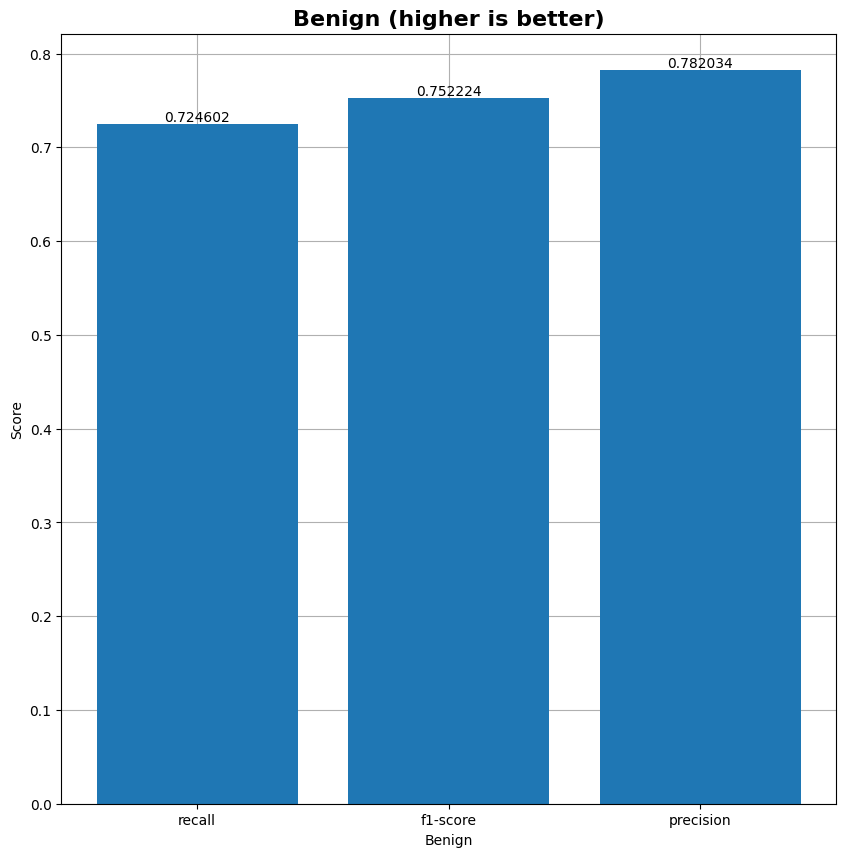

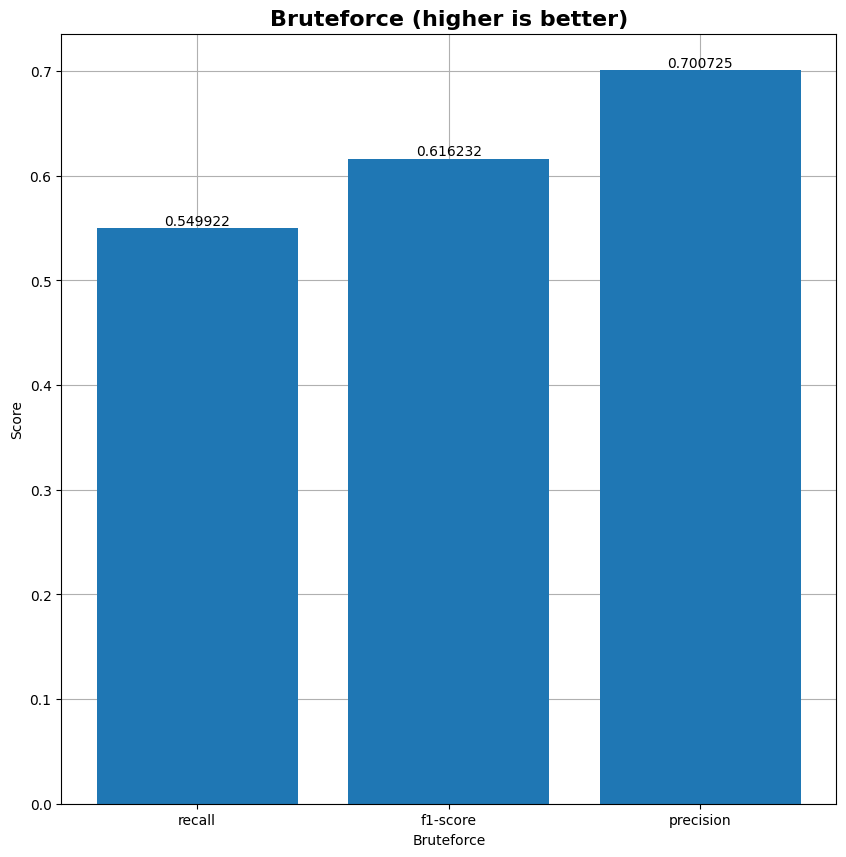

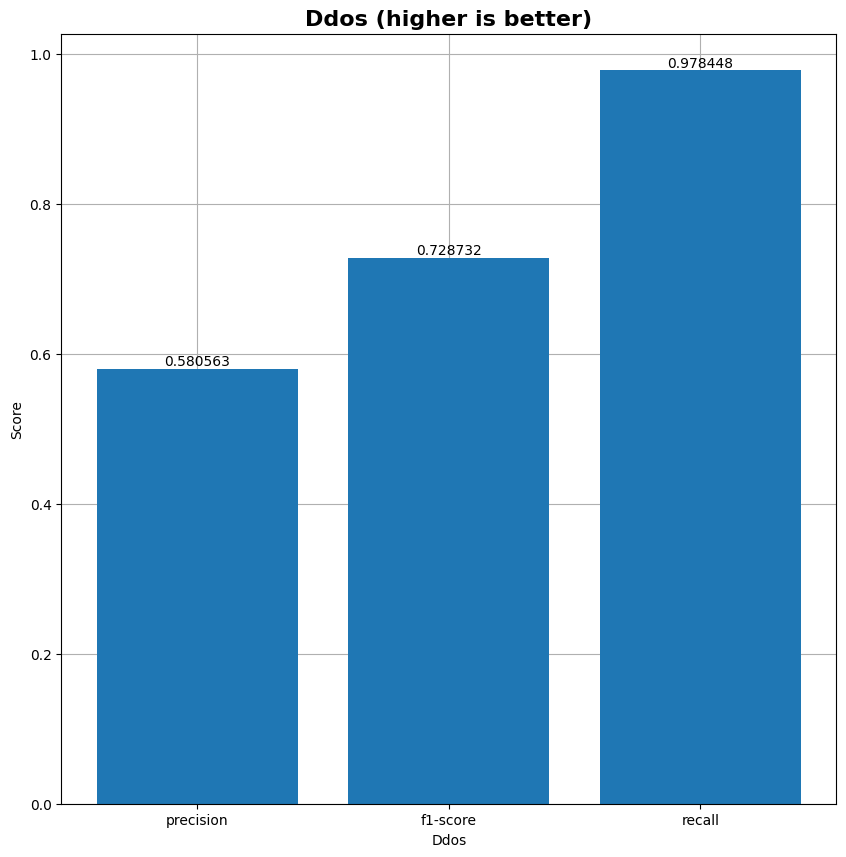

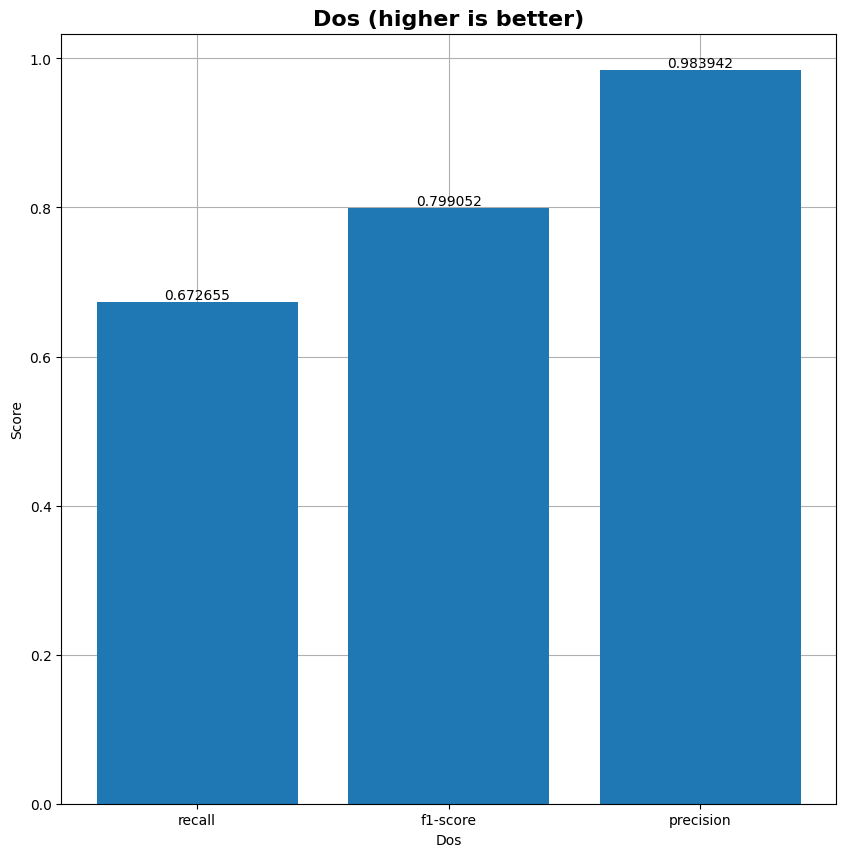

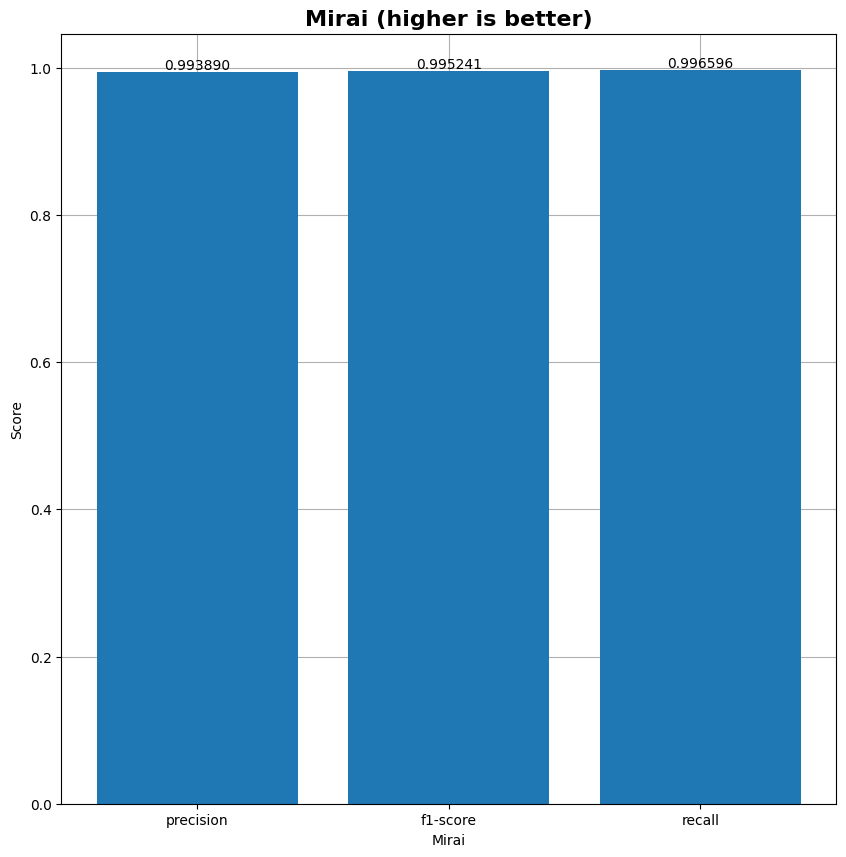

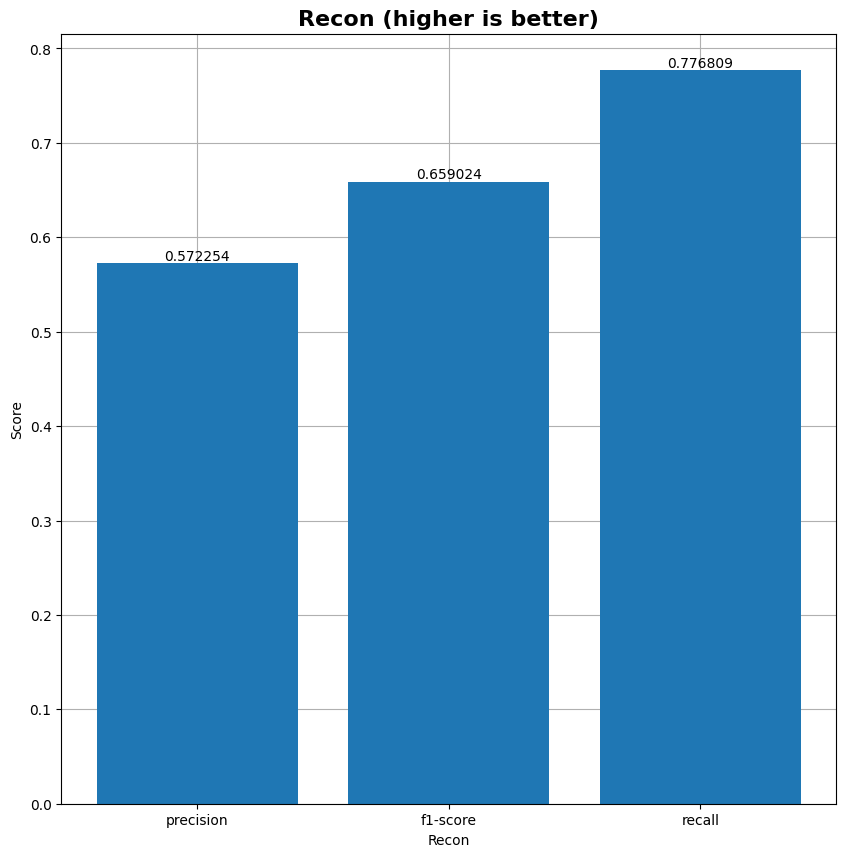

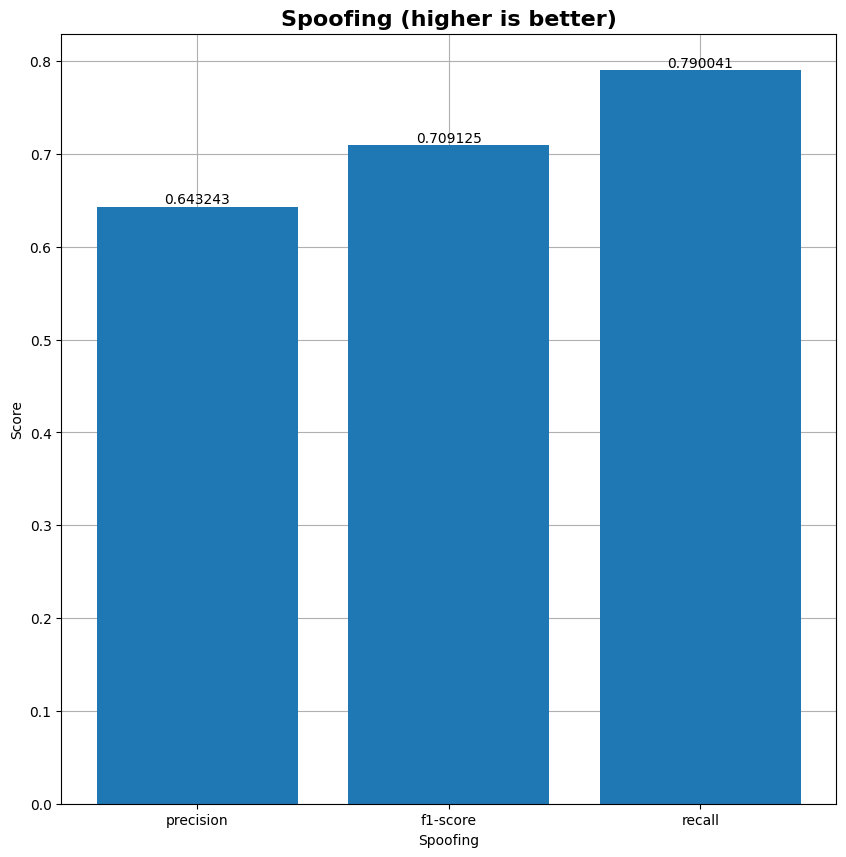

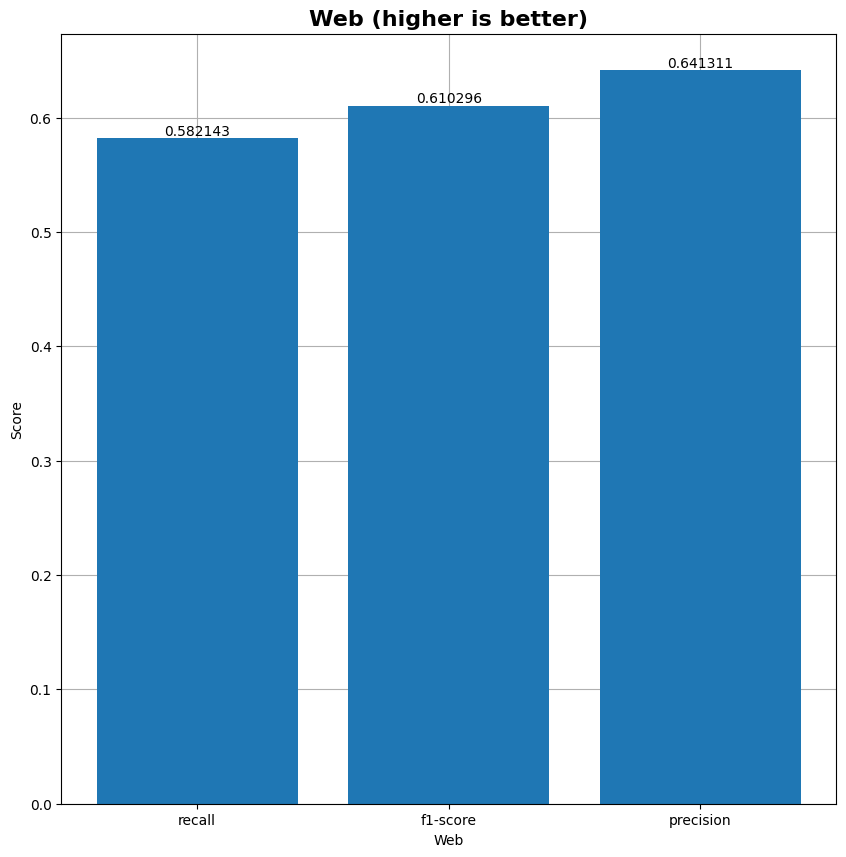

In [123]:
plot_mc(y_pred, y_test, "FF-NN")

In [ ]:
model_name = "FFNN_10000.sav"
pickle.dump(model, open(model_name, 'wb'))

# LSTM

In [124]:
# Prepare sequential data
def create_sequences(features, labels, seq_length):
    sequences, seq_labels = [], []
    for i in range(len(features) - seq_length):
        sequences.append(features[i:i + seq_length])
        seq_labels.append(labels[i + seq_length - 1])  # Use the last label in the sequence
    return np.array(sequences), np.array(seq_labels)

In [125]:
num_components = len(np.unique(y))

In [126]:
# Create sequences
seq_length = 20
X1, y1 = create_sequences(X, y, seq_length)
y1 = to_categorical(y1, num_classes=num_components)  # Convert labels to one-hot encoding

In [127]:
# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X1, y1, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [128]:
def create_model_LSTM(input_shape, num_classes):
    model = keras.Sequential([
        keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True),
        keras.layers.Dropout(0.3),
        keras.layers.LSTM(32),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(num_classes, activation='softmax')  # Use softmax for multi-class classification
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [129]:
# Build model
model = create_model_LSTM(input_shape=(seq_length, X1.shape[2]), num_classes=num_components)

/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [130]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 20, 64)         │        28,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,464 (169.78 KB)

 Trainable params: 43,464 (169.78 KB)

 Non-trainable params: 0 (0.00 B)

In [131]:
%%time

start = time.time()

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

# Evaluate model
y_pred = model.predict(X_test)

end = time.time()

LSTM_Time = end - start

Epoch 1/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.9316 - loss: 0.2489 - val_accuracy: 0.9955 - val_loss: 0.0171
Epoch 2/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9977 - loss: 0.0102 - val_accuracy: 0.9990 - val_loss: 0.0051
Epoch 3/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.9984 - loss: 0.0077 - val_accuracy: 0.9987 - val_loss: 0.0058
Epoch 4/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.9991 - loss: 0.0034 - val_accuracy: 0.9992 - val_loss: 0.0040
Epoch 5/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.9991 - loss: 0.0052 - val_accuracy: 0.9991 - val_loss: 0.0056
Epoch 6/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9992 - loss: 0.0040 - val_accuracy: 0.9937 - val_loss: 0.0184
Epoch 7/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.9991 - loss: 0.0039 - val_accuracy: 0.9984 - val_loss: 0.0066
Epoch 8/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.9996 - loss: 0

In [132]:
_, accuracy = model.evaluate(X_test, y_test)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9997 - loss: 0.0023    


In [133]:
y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

In [134]:
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [135]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, LSTM_Time]
results_dict["LSTM"] = results

In [136]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [137]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.710167,0.717006,0.710863,0.710167,0.669535,1.092000,5.557500,2.357435,1.153106
RF,0.891667,0.895353,0.891747,0.891667,0.876699,0.404750,2.019083,1.420945,4.113602
XGBoost,0.908000,0.911600,0.908041,0.908000,0.895363,0.358583,1.804250,1.343224,5.455152
LightGBM,0.905833,0.909963,0.905908,0.905833,0.892957,0.369417,1.876250,1.369763,3.653643
FF-NN,0.732333,0.759801,0.731702,0.732333,0.697839,0.932917,4.596250,2.143887,191.809011
LSTM,0.999833,0.999833,0.999833,0.999833,0.999809,0.000417,0.001417,0.037643,142.685586


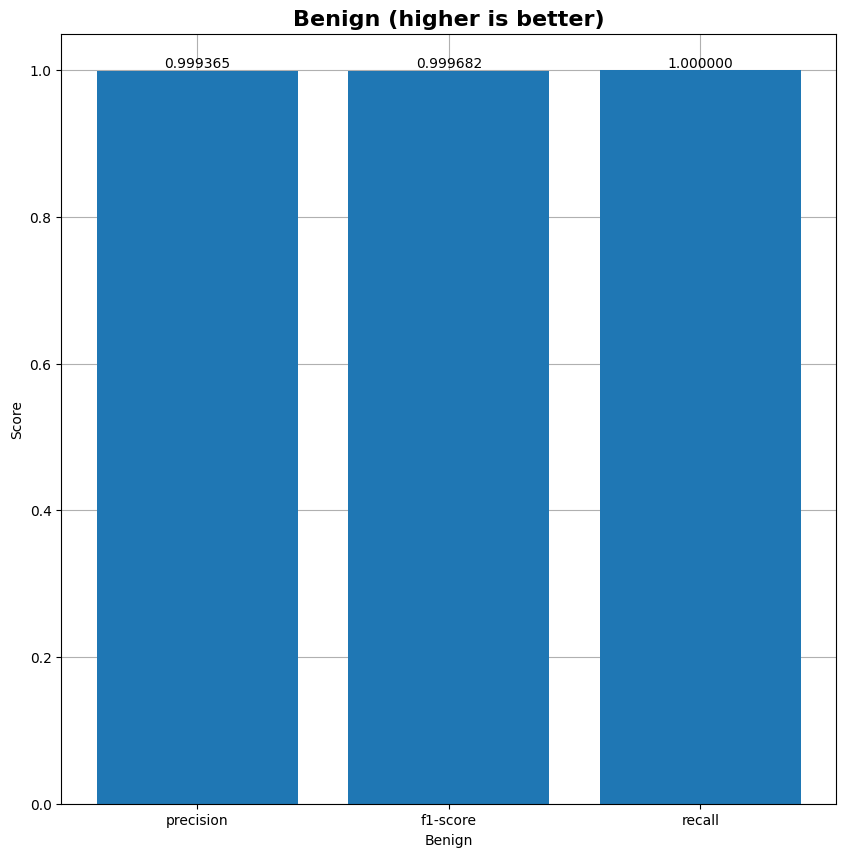

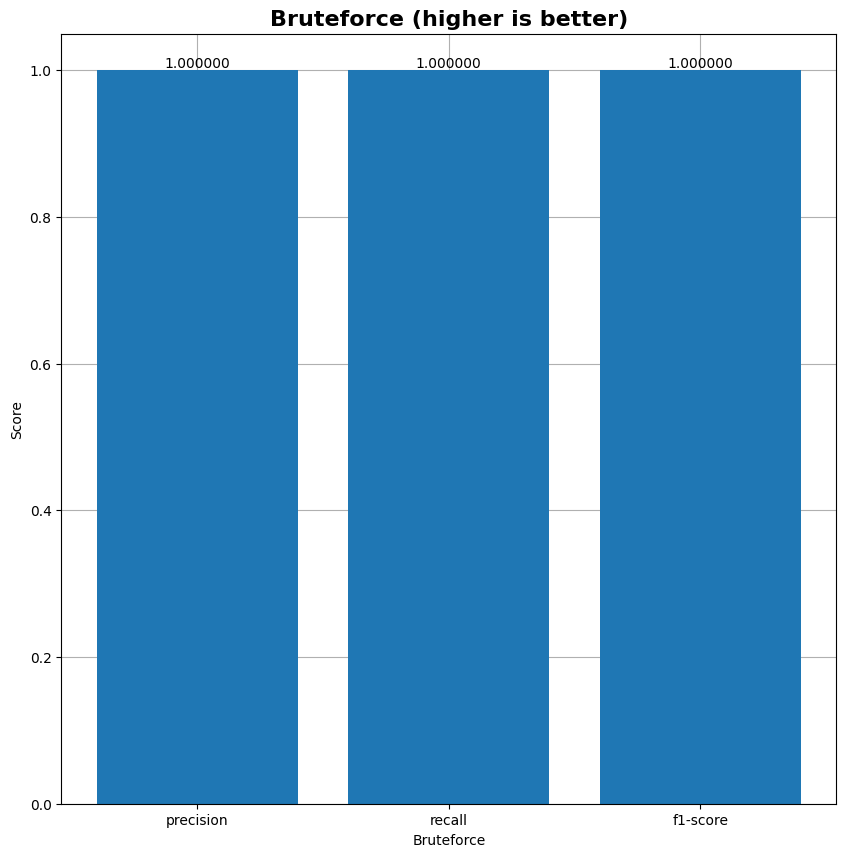

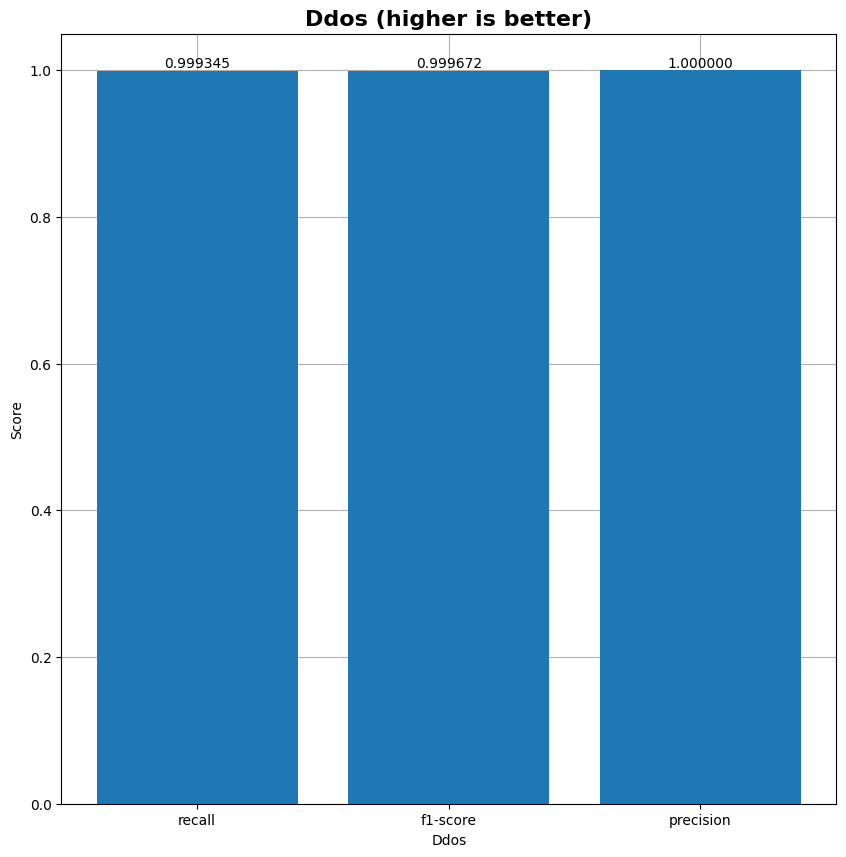

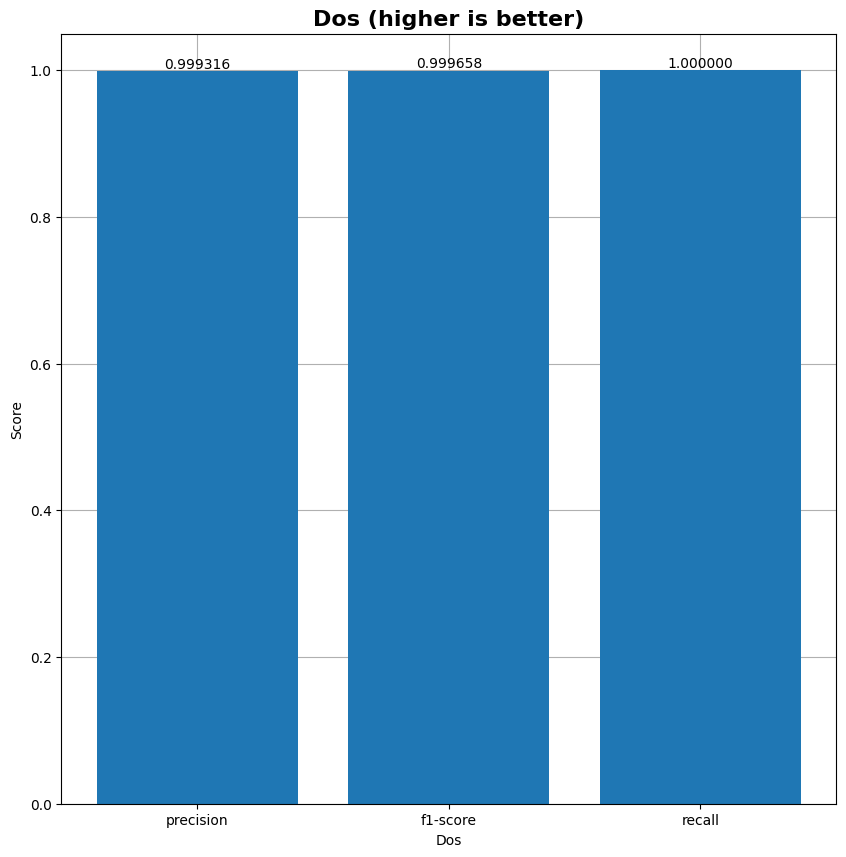

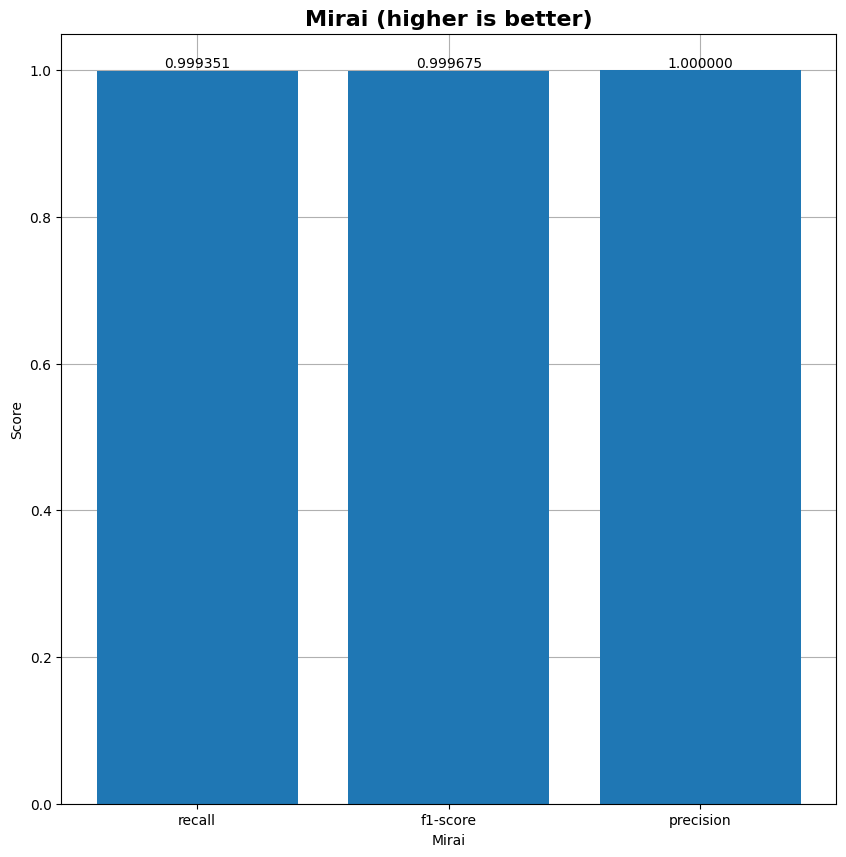

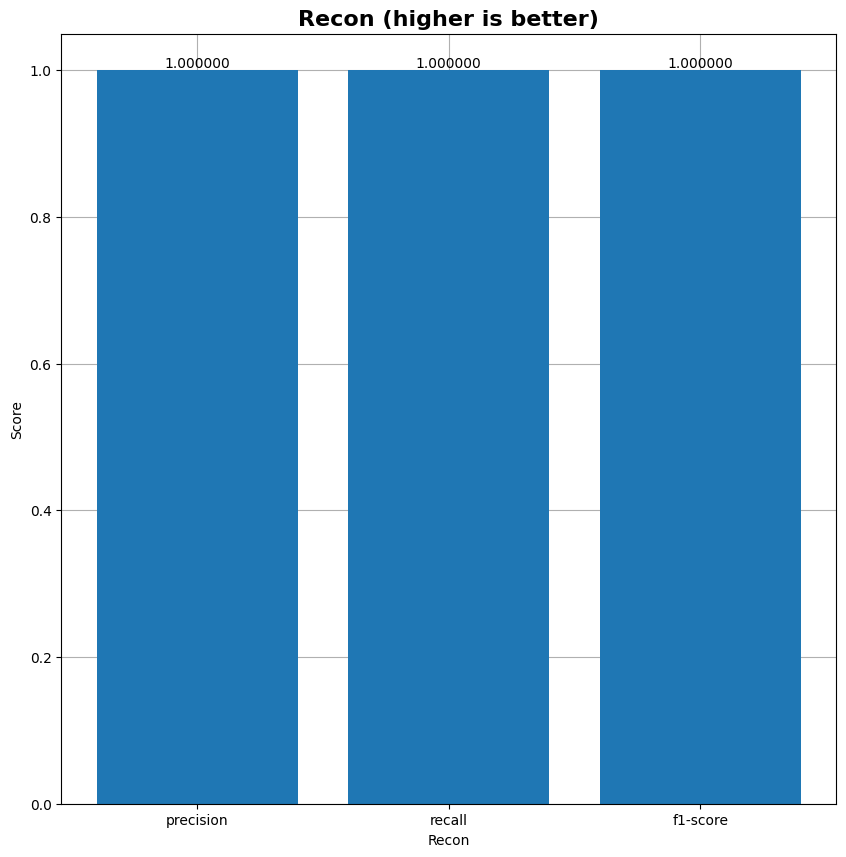

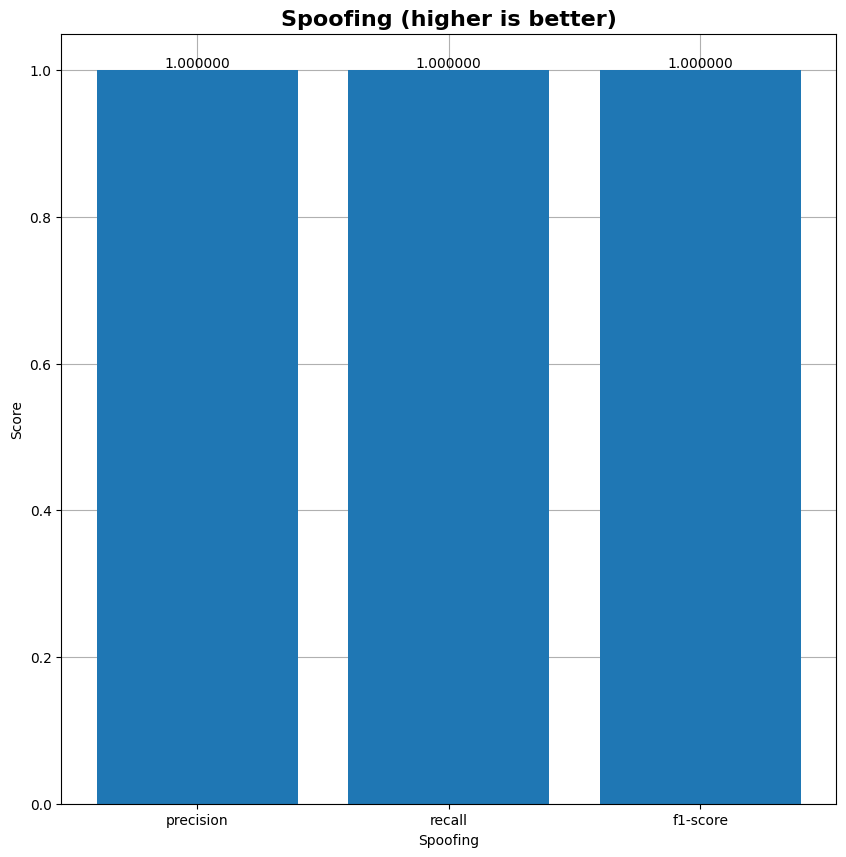

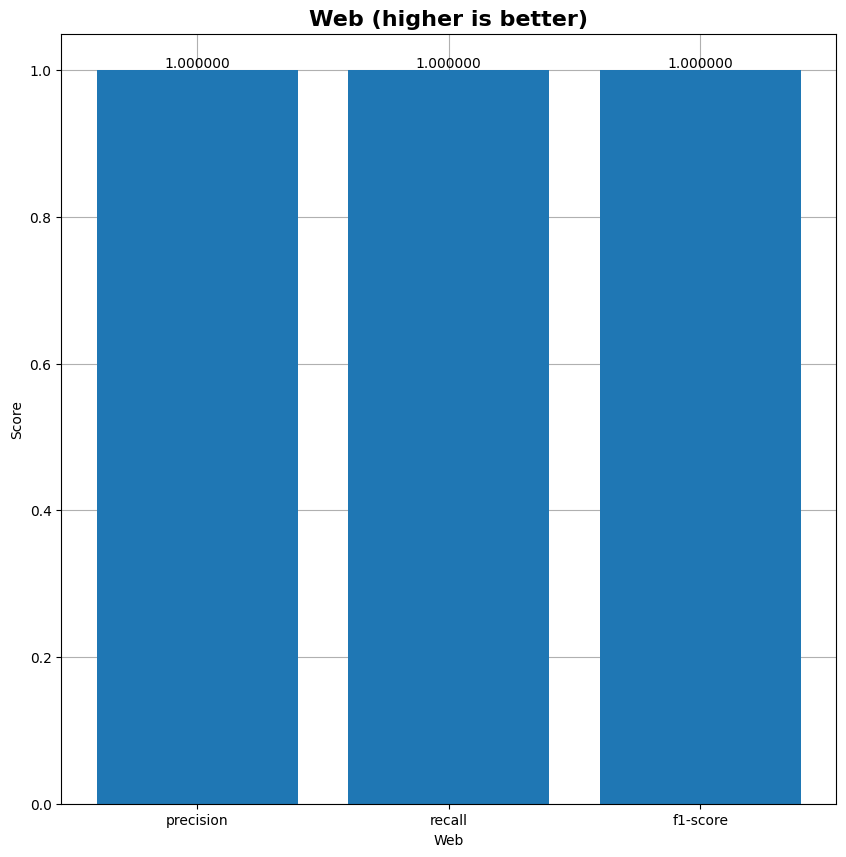

In [138]:
plot_mc(y_pred, y_test, "LSTM")

In [ ]:
model_name = "LSTM_10000.sav"
pickle.dump(model, open(model_name, 'wb'))

# Plot data

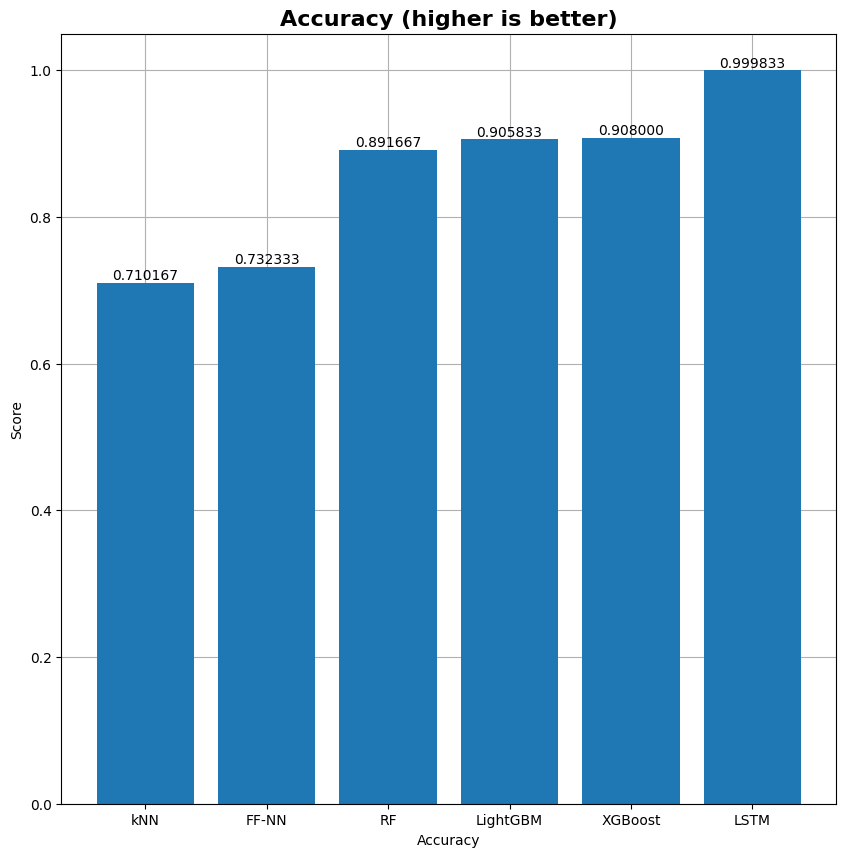

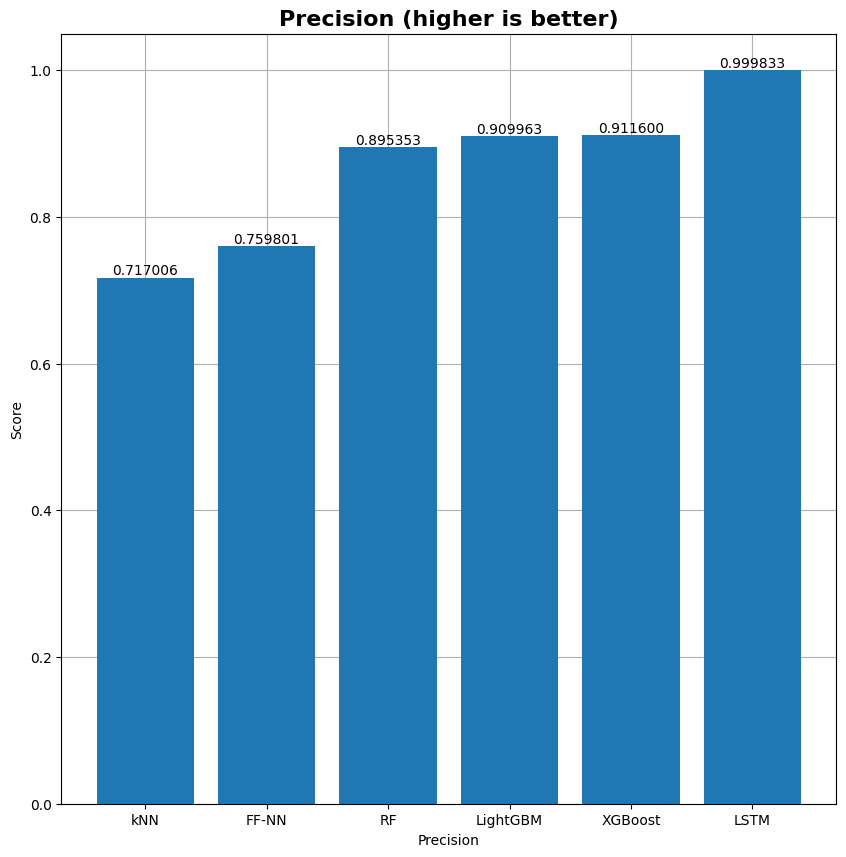

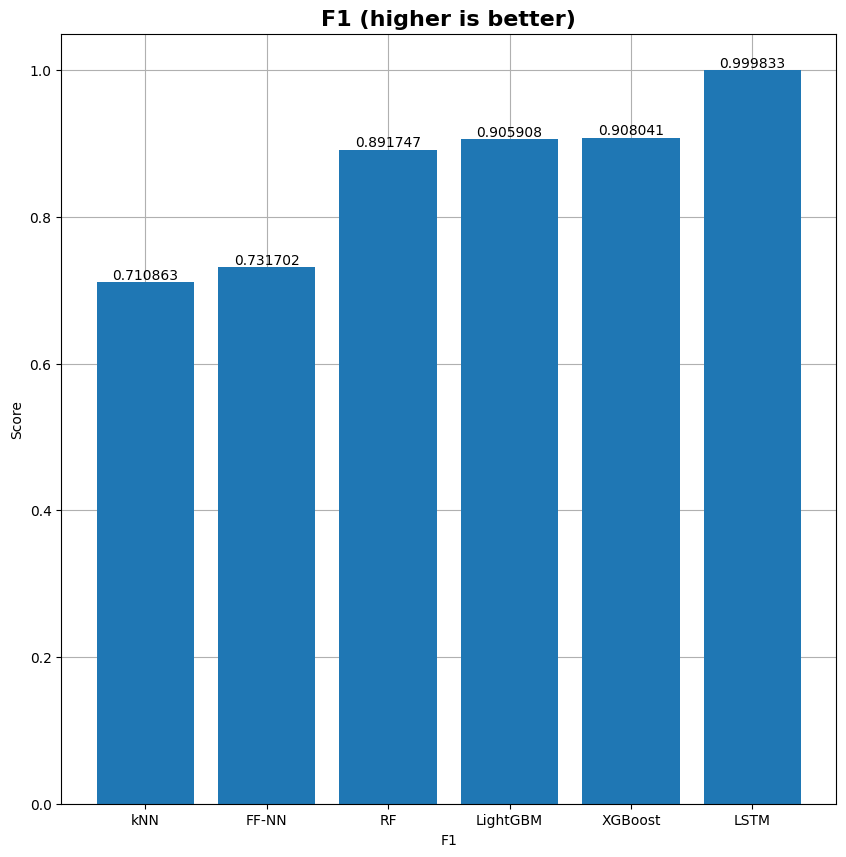

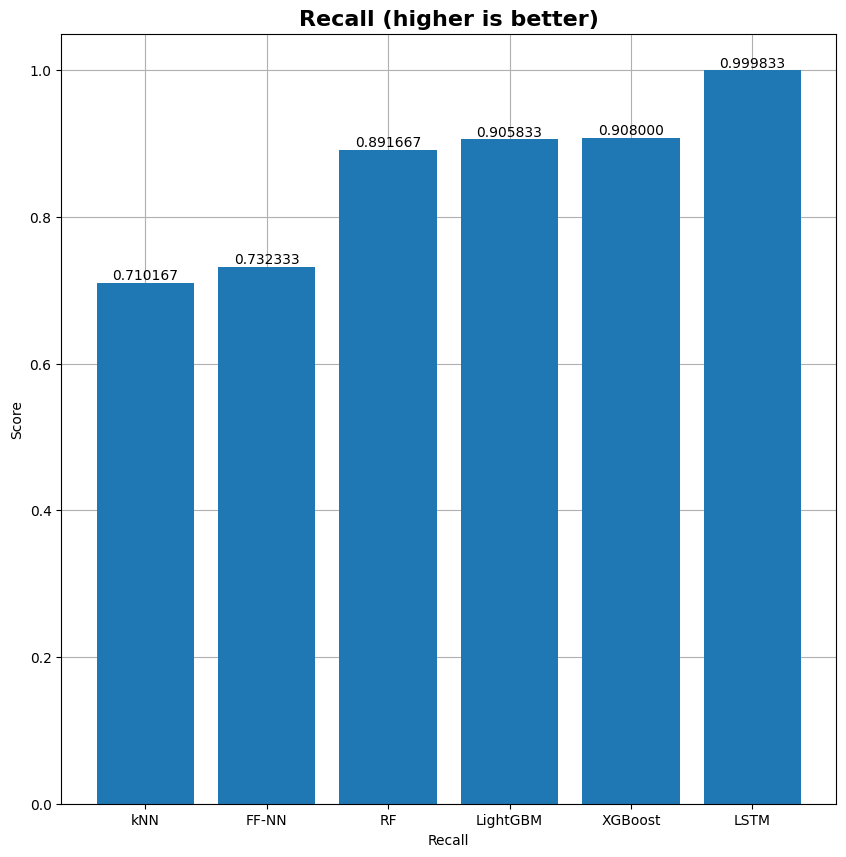

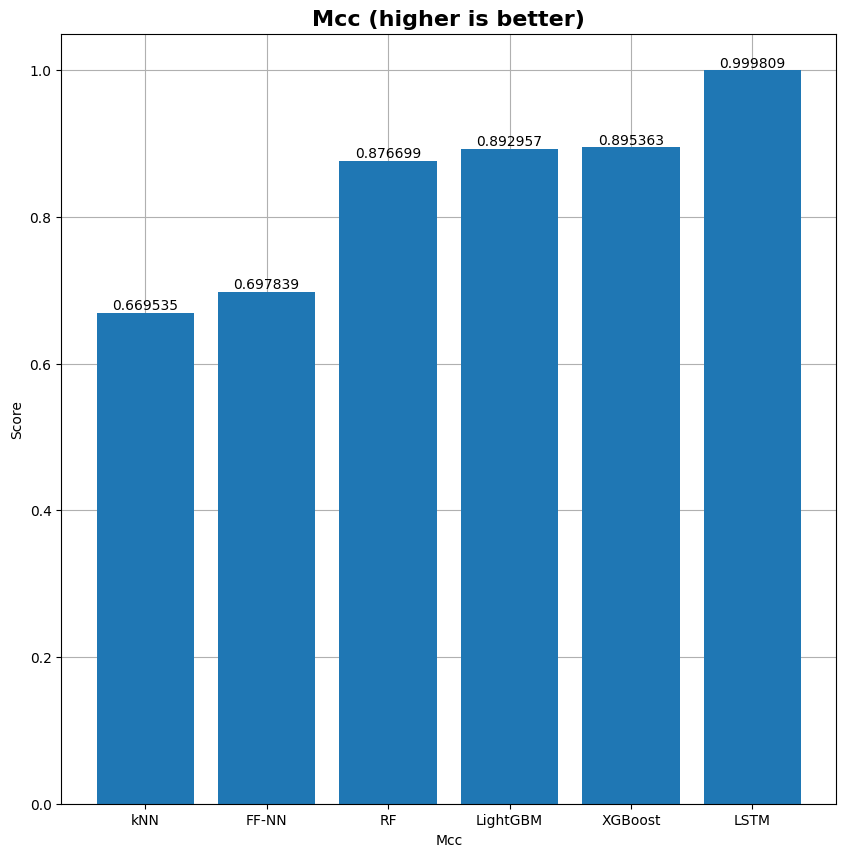

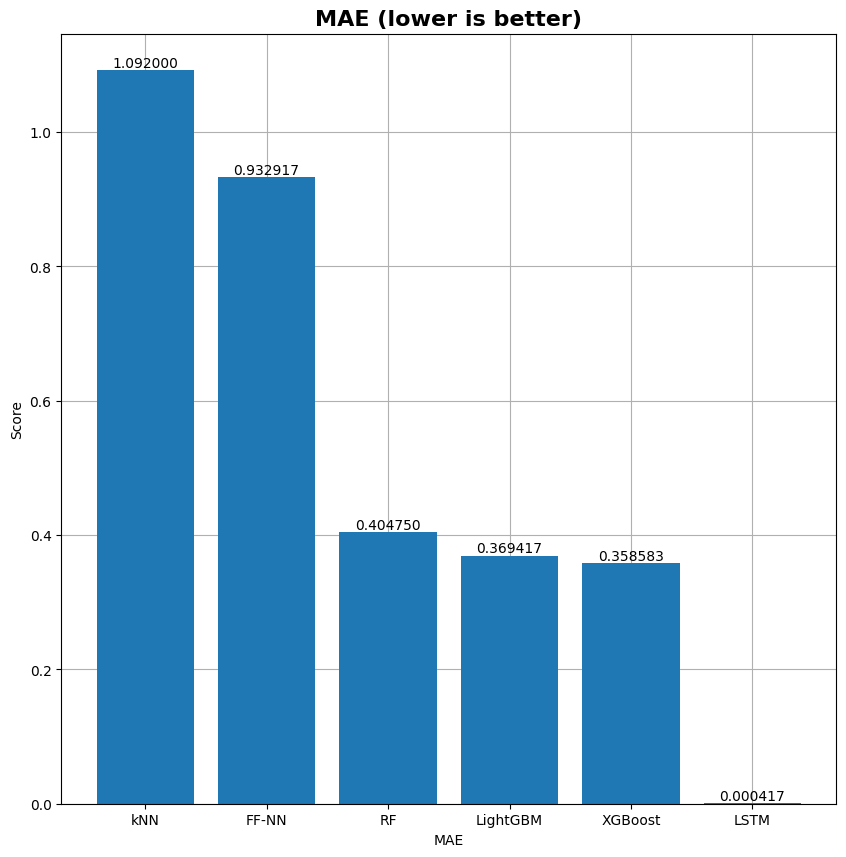

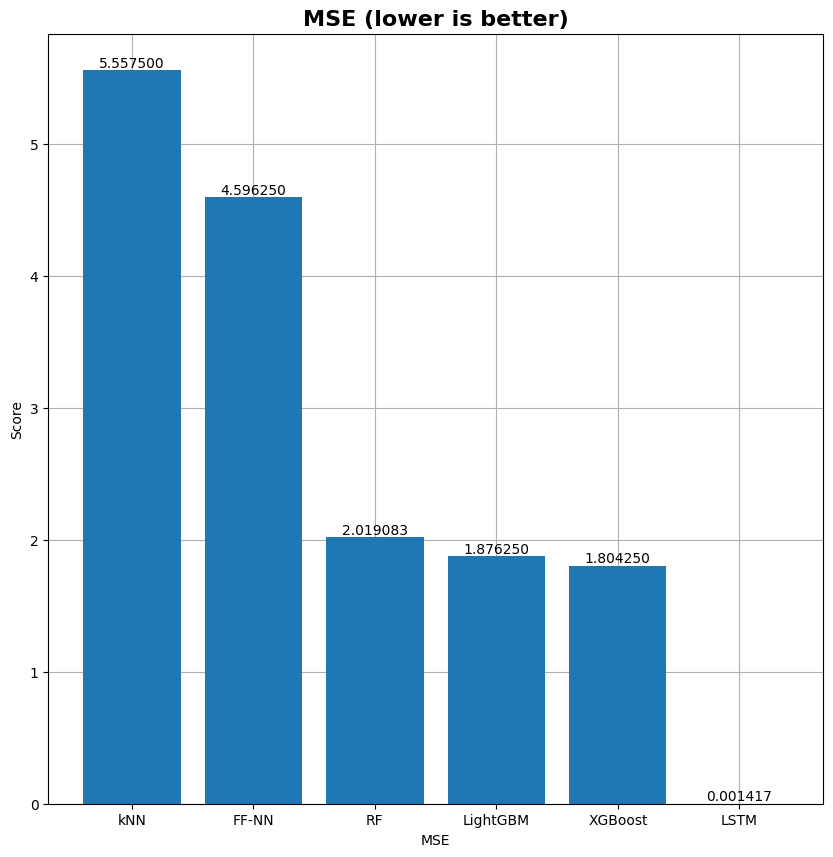

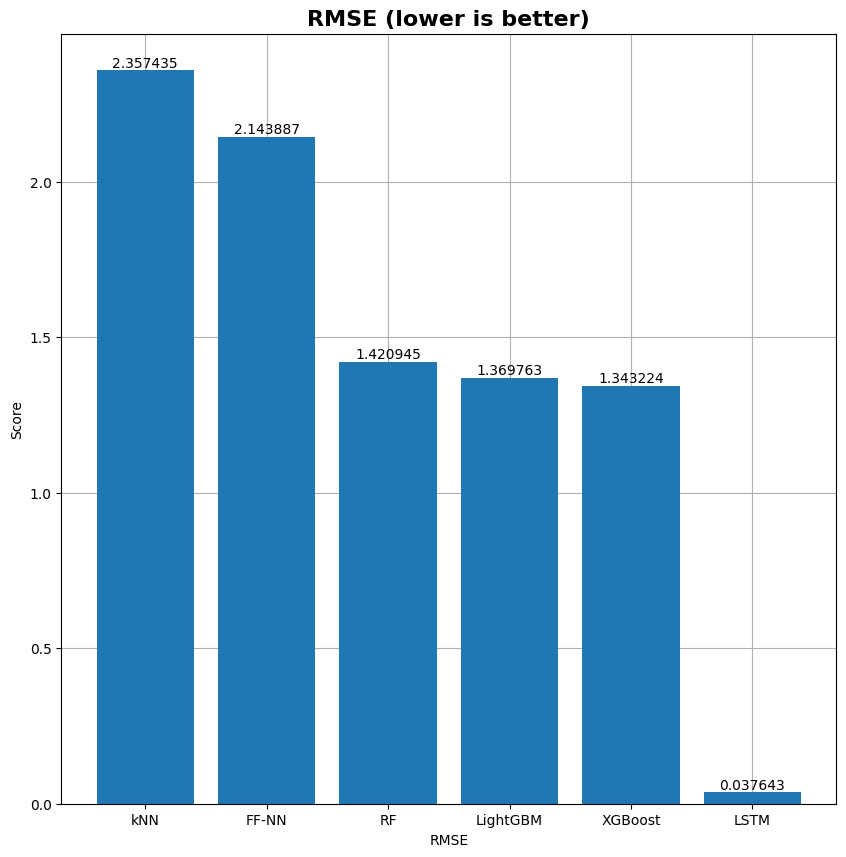

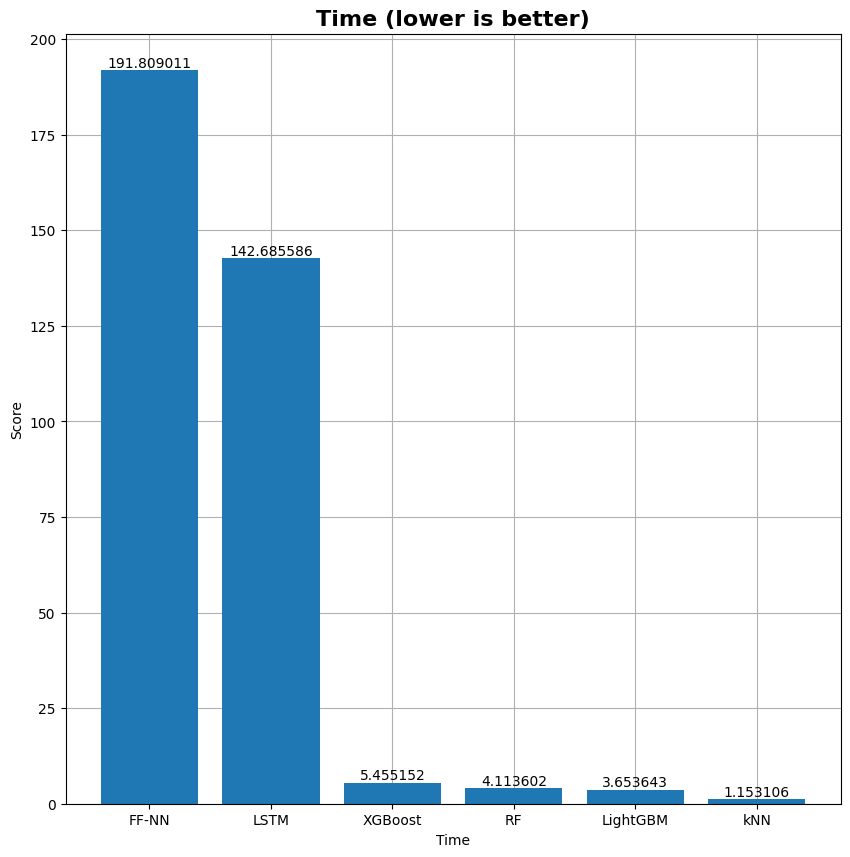

In [139]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])
for x in results_df:
    _dict = {}
    name = results_df[x].name
    for keys, values in zip(range(len(results_df[x].keys())), results_df[x]):
        _dict[results_df[x].keys()[keys]] = values
    result_plot(_dict, name, "multiclass", "")

# Save results dict

In [140]:
df_dict = results_df.to_dict()

In [141]:
values = ['Precision', 'Recall', 'F1']
new_dict = {}
for value in values:
    new_dict[value] = df_dict[value]

In [142]:
new_dict

{'Precision': {'kNN': 0.7170061293731683,
  'RF': 0.8953530108974643,
  'XGBoost': 0.9115998844078164,
  'LightGBM': 0.9099629888410494,
  'FF-NN': 0.7598014514494384,
  'LSTM': 0.9998334004049882},
 'Recall': {'kNN': 0.7101666666666666,
  'RF': 0.8916666666666667,
  'XGBoost': 0.908,
  'LightGBM': 0.9058333333333334,
  'FF-NN': 0.7323333333333333,
  'LSTM': 0.9998332916562473},
 'F1': {'kNN': 0.710862700062696,
  'RF': 0.8917474036224347,
  'XGBoost': 0.9080411363162313,
  'LightGBM': 0.9059083371943341,
  'FF-NN': 0.731702064837721,
  'LSTM': 0.9998332913602931}}

In [143]:
pd.DataFrame(new_dict).transpose()

,kNN,RF,XGBoost,LightGBM,FF-NN,LSTM
Precision,0.717006,0.895353,0.911600,0.909963,0.759801,0.999833
Recall,0.710167,0.891667,0.908000,0.905833,0.732333,0.999833
F1,0.710863,0.891747,0.908041,0.905908,0.731702,0.999833
